# Учебный проект №3
# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Задача — установить параметры, отследить аномалии и, возможно, мошенническую деятельность. 
<br>
По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных.
<br>
На первом этапе необходимо выполнить предобработку данных - по возможности, заполнить пропуски, удалить редкие значения.
<br>На втором этапе проведём исследовательский анализ данных.<br>
На третьем этапе будем выявлять факторы, влияющие на цену недвижимостии, попутно, решать дополнительные задачи.

## Откройте файл с данными и изучите общую информацию. 

In [143]:
# блок загрузки библиотек
import pandas as pd
import warnings
import matplotlib.pyplot as plt

# скрываем предупреждения
warnings.filterwarnings('ignore')

In [144]:
try:
    data = pd.read_csv('real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('network path hidden', sep='\t')
display(data.info())    
data.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

None

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


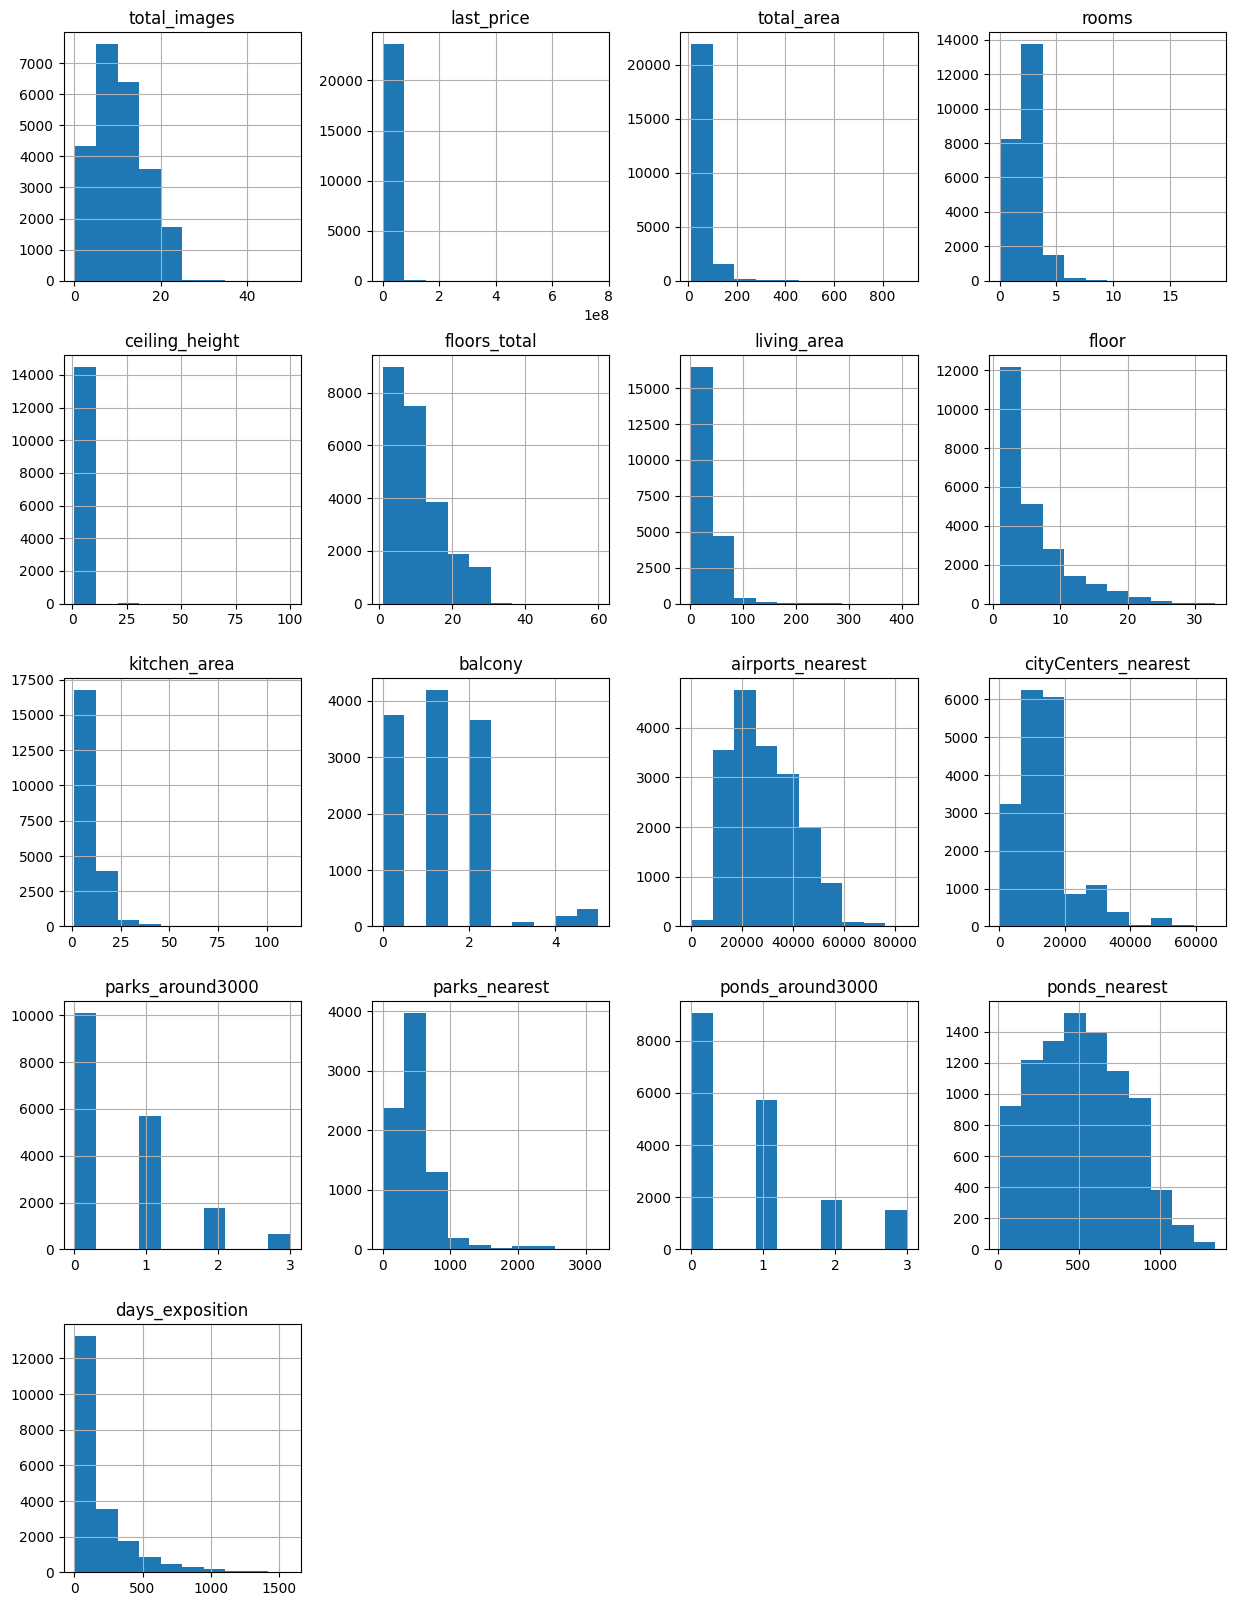

In [145]:
# построим гистрограммы для знакомства с данными
data.hist(figsize=(15, 20));

<b> Первое знакомство </b>
Файл открыт. Беглый осмотр первых строк сразу показывает большое количество пропущенных данных.
Первичные гистограммы говорят о том же, плюс, судя по всему есть аномальные значения:
- total_images (количество фото), основная масса в диапазоне 1-20, но встречаются объявления с 30+, явно какая-то ошибка
- last_price гистограмму надо перестроить, эта непоказательна из-за ограничения в 80млн, основная масса собрана в районе до 10 млн, возможны выбросы (ошибка или супер-дорогие объекты)
- total_area - по общей площади основной объём объектов собран до 100кв.м, но есть выбросы больше 200, что сместило правую границу гистрограммы до 800 кв.м
- rooms - количество комнат, основной объём объектов до 5 комнат (больше 2-3), но, опять же из-за выбросов гистограмма размечена до 15-20
- похожая ситуция со многими характеристиками (высота потолков, этажность, площадь кухни, и, даже, с количеством дней экспозиции) - основная масса объектов характеризуется адекватными величинами, но из-за наличия выбросов (ошибки или аномалии) правые границы соответствующих гистограмм сильно смещены вправо. Необходима предобработка данных - удаление дубликатов явных и неявных, выявляение пропусков (с последующим заполнением или удалением), исправление ошибок.

## Предобработка данных

In [146]:
#оценим наличие явных дубликатов в датасете (ДС)
data.duplicated().sum()

0

In [147]:
# пропущенные значения бары
def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = 0, legend = False, fontsize = 16)
            .set_title('Процент пропусков данных по столбцам' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) ')

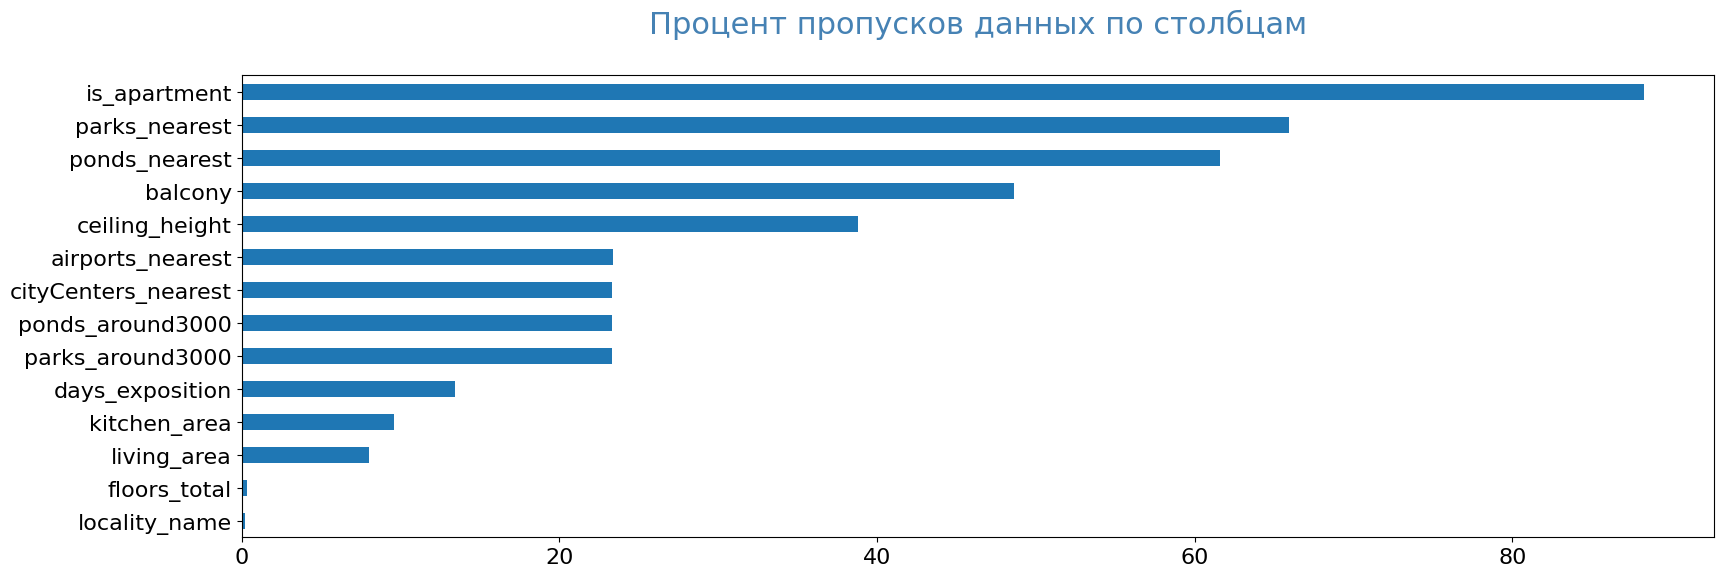

In [148]:
pass_value_barh(data)

Очень большое количество пропусков как в данных, вносимых пользователями, так и в картографических. Вероятно, придётся либо избавляться от них, либо заполнять средними/медианными значениями. Но, т.к. в случае с недвижиостью очень важна её локация, считаю необходимым удостовериться, что нет проблем в названиях локаций, навести там порядок.

### Местоположение

In [149]:
#исследуем уникальные значения столбца locality_name
display(data['locality_name'].nunique())
data['locality_name'].sort_values().unique()

364

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

В названиях большое количество неявных дубликатов, разных вариантов названий одних и тех же населённых пунктов. Попробуем избавиться.

In [150]:
# удалим неявные дубликаты (такое задание есть в списке дальше, но сделаю сейчас)
# 
# также дополним таблицу столбцом типом локации (столица - для Питера, город - для городов, поселок для посёлков(ПГТ)
# деревня для деревень и сёл

# пропуски заполним "NoName"
data['locality_name'] = data['locality_name'].fillna(value='NoName')


# заменим буквы ё на е
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')

# создадим список уникальных названий населённых пунктов names без типа насел.пункта, в uniloc положим уникальные локации
names=data['locality_name'].drop_duplicates().reset_index(drop = True).to_frame()
uniloc=data['locality_name'].drop_duplicates().reset_index(drop = True).to_frame()
list=[]
for i in ['садовое товарищество ',\
          'деревня ',\
          'коттеджный поселок ',\
          'садоводческое некоммерческое товарищество ',\
          'поселок при железнодорожной станции ',\
          'поселок городского типа ',\
          'городской поселок ',\
          'поселок станции ',\
          'поселок ',\
          'село ']:
    names['locality_name'] = names['locality_name'].str.replace(i, '')
names=set(names['locality_name'])

# проанализируем, какие названия встречаются больше 1 раза - вероятны неявные дубликаты
# все такие названия включим в отдельный список list
for i in names:
    if uniloc['locality_name'].str.contains(str(i)).sum() > 1:
        list.append(i)
uniloc=uniloc.dropna()
for i in list:
    print(i, uniloc[uniloc['locality_name'].str.contains(i)])
    print()
        

Федоровское                      locality_name
14             деревня Федоровское
107  городской поселок Федоровское

Кингисепп              locality_name
29               Кингисепп
240  поселок Кингисеппский

Рябово                       locality_name
115                  поселок Рябово
179  поселок городского типа Рябово

Лесогорский                            locality_name
94         городской поселок Лесогорский
232  поселок городского типа Лесогорский

Высоцк             locality_name
191  село Русско-Высоцкое
280                Высоцк

Рабитицы         locality_name
151  деревня Рабитицы
317  поселок Рабитицы

Павлово                        locality_name
63                      село Павлово
91         городской поселок Павлово
221  поселок городского типа Павлово

Назия                      locality_name
156        городской поселок Назия
250  поселок городского типа Назия

Бегуницы                locality_name
119         деревня Бегуницы
162  деревня Старые Бегуницы

Вещево    

Из получившегося списка названий вероятных дублей нужно оставить только реальные дубли, для дальнейшей обработки исходного датасета

In [151]:
# список на удаление 
for i in ['Бор', 'Свирь', 'Кингисепп', 'Ропша', 'Русско', 'Рахья', 'Бегуницы', 'Высоцк', 'Коммунар', 'Старая', 'Приладожский']:
    list.remove(i)

# теперь в list список дублей
# т.к. абсолютное большинство насел.пунктов это посёлки, считаю возможным назвать их всех посёлками, кроме Кудрово - деревня
for i in list:
    data.loc[data['locality_name'].str.contains(i), 'locality_name'] = 'поселок '+ i
data.loc[data['locality_name'].str.contains('Кудрово'), 'locality_name'] = 'деревня Кудрово'

In [152]:
# анализ уникальных значений локаций - заметно сокращение
data['locality_name'].nunique()

306

In [153]:
# следующий этап - категоризация по типу населённого пункта: столица, город, поселок, деревня, другое (сюда же пока отложим NoName)
# сделаем с помощью функции и метода apply
def loc_type(row):
    if 'поселок' in row:
        return 'поселок'
    elif 'NoName' in row:
        return "другое"
    elif 'деревн' in row or 'сад' in row:
        return 'деревня'
    else:
        return 'город'
data['locality_type'] = data['locality_name'].apply(loc_type)
data.loc[data['locality_name'] == 'Санкт-Петербург', 'locality_type'] = 'столица'

### Расстояние до центра и аэропорта
Данные о расстоянии до центра должны быть добавлены автоматически (картографическая информация), судя по описанию ДС.
Вероятно, произошёл сбой в определении местоположения локации, попробуем заместить информацию медианой

In [154]:
# проанализируем пропуски расстояние до центра
data['cityCenters_nearest'].isna().sum()

5519

In [155]:
# изучим распределение имеющихся данных по расстоянию до центра
data['cityCenters_nearest'].describe()

count    18180.000000
mean     14191.277833
std       8608.386210
min        181.000000
25%       9238.000000
50%      13098.500000
75%      16293.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

Значения выглядят правдоподобными, их можно использовать для анализа и заполнения пропусков

In [156]:
# попробуем заполнить пропуски расстояния до центра на основе медианных значений соответствующих населённых пунктов
for i in data['locality_name'].unique():
    data.loc[(data['cityCenters_nearest'].isna()) & (data['locality_name'] == i), 'cityCenters_nearest']\
    = data.loc[data['locality_name'] == i, 'cityCenters_nearest'].median()
data['cityCenters_nearest'].isna().sum()  

4829

In [157]:
# осталось ещё много пропусков, проверим, как распределись пропуски по типам населённых пунктов
data.query('cityCenters_nearest.isna() == True').pivot_table(index='locality_type', values='locality_name', aggfunc='count')

,locality_name
locality_type,
город,2387
деревня,1090
поселок,1352


In [158]:
# попробуем теперь заполнить пропуски расстояния до центра на основе медианных значений соответствующих *типов* населённых пунктов
for i in data['locality_type'].unique():
    data.loc[(data['cityCenters_nearest'].isna()) & (data['locality_type'] == i), 'cityCenters_nearest']\
    = data.loc[data['locality_type'] == i, 'cityCenters_nearest'].median()
data['cityCenters_nearest'].isna().sum() 

1090

Пропуски остались только в типе "деревня", данных по ним нет. Можно заполнить медианой по типу "посёлок", т.к. это тоже "загородная недвижимость"

In [159]:
data['cityCenters_nearest'].fillna(data.loc[data['locality_type'] == 'поселок', 'cityCenters_nearest'].median(), inplace = True)
data['cityCenters_nearest'].isna().sum() 

0

In [160]:
# изучим распределение имеющихся данных по расстоянию до аэропорта
data['airports_nearest'].describe()

count    18157.000000
mean     28793.672193
std      12630.880622
min          0.000000
25%      18585.000000
50%      26726.000000
75%      37273.000000
max      84869.000000
Name: airports_nearest, dtype: float64

In [161]:
# проделаем аналогичные действия с расстоянием до аэропорта
# оценим пропуски
data['airports_nearest'].isna().sum()

5542

Данные о расстоянии до аэропорта должны быть добавлены автоматически (картографическая информация), судя по описанию ДС. 

Вероятно, произошёл сбой в определении местоположения локации, попробуем заместить информацию медианой по соответствующим населенными пунктам, где информация есть
По остальным населенным пунктам пропуски заполним по общей медиане.

In [162]:
for i in data['locality_name'].unique():
    data.loc[(data['airports_nearest'].isna()) & (data['locality_name'] == i), 'airports_nearest']\
    = data.loc[data['locality_name'] == i, 'airports_nearest'].median()

In [163]:
data['airports_nearest'].fillna(data['airports_nearest'].median(), inplace = True)
data['airports_nearest'].isna().sum()  

0

В обоих столбцах большое количество пропущенных значений заполнено медианой. Возможно, какой-то сбой при заполнении расстояния до аэропорта. Что касается расстояния до городского центра, то заметно большое количество пропусков именно в отношении городов. Возможно, городской центр у каждого такого населенного пункта свой? Другая версия - расстояние до аэропорта или центра так велико, что показывать его в объявлении нерезонно. А за медиану, возмжно, придётся "расплачиваться" потерей красоты графиков.

Следующим шагом попробуем выяснить, что скрывается за названием NoName

In [164]:
data[data['locality_name'] == 'NoName'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49 entries, 1097 to 23214
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          49 non-null     int64  
 1   last_price            49 non-null     float64
 2   total_area            49 non-null     float64
 3   first_day_exposition  49 non-null     object 
 4   rooms                 49 non-null     int64  
 5   ceiling_height        14 non-null     float64
 6   floors_total          48 non-null     float64
 7   living_area           44 non-null     float64
 8   floor                 49 non-null     int64  
 9   is_apartment          15 non-null     object 
 10  studio                49 non-null     bool   
 11  open_plan             49 non-null     bool   
 12  kitchen_area          40 non-null     float64
 13  balcony               43 non-null     float64
 14  locality_name         49 non-null     object 
 15  airports_nearest   

По всем строкам есть информация о расстоянии до центра и до аэропорта. Посмотрим, как эти величины распределены. Сравним с областным центром.

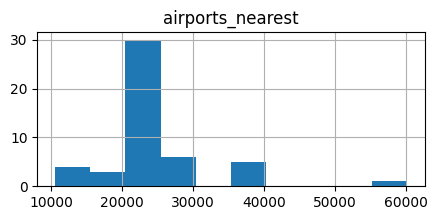

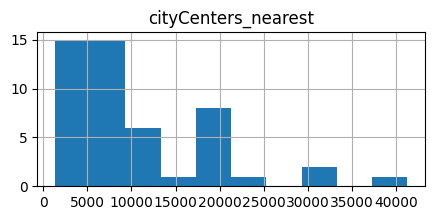

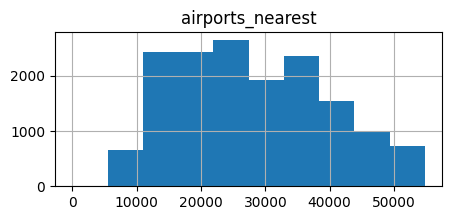

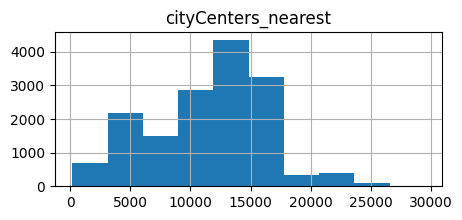

In [165]:
data[data['locality_name'] == 'NoName'].hist('airports_nearest', figsize=(5,2));
data[data['locality_name'] == 'NoName'].hist('cityCenters_nearest', figsize=(5,2));
data[data['locality_name'] == 'Санкт-Петербург'].hist('airports_nearest', figsize=(5,2));
data[data['locality_name'] == 'Санкт-Петербург'].hist('cityCenters_nearest', figsize=(5,2));

Близость к аэропорту (до 50км) и центру города (до 25 км) может косвенно свидетельствовать о том, что это объекты, расположенные в Санкт-Петербурге. Остальные - оставим в статусе без имени.

In [166]:
data.loc[(data['locality_name'] == 'NoName') &\
     (data['airports_nearest'] <= 50000) &\
     (data['cityCenters_nearest'] <= 25000),\
     'locality_name'] = 'Санкт-Петербург'
data.loc[data['locality_name'] == 'Санкт-Петербург', 'locality_type'] = 'столица'

# сразу оценим, сколько осталось нонеймов
len(data[data['locality_name'] == 'NoName'])

3

После обработки в ДС осталось только 3 объекта ноунейм, они сильно удалены от центра и аэропорта - не попадают в распределение по СПб, значит, достоверно нельзя присвоить им название населённого пункта.

### Балконы и апартаменты

In [167]:
# если информации о балконах нет, вероятней всего, и балкона нет, можно заполнить пропуски 0
data['balcony'].fillna(0, inplace = True)

data['balcony'] = data['balcony'].astype(int)
data['balcony'].describe()

count    23699.000000
mean         0.591080
std          0.959298
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          5.000000
Name: balcony, dtype: float64

Возможно, и есть жильё с 5 балконами... Пока оставим эти данные

In [168]:
# по причине не большой популярности апартаментов, считаю возможным применить этот же способ заполнения пропусков в столбце 'is_apartment'
data['is_apartment'].fillna(False, inplace = True)

### Пруды и парки рядом

Наличие прудов и парков является критически важным в мегаполисе, в небольших городах, а, тем более, для загородной недвижимости, это не столь важный показатель, т.к. является в наличии "по умолчанию", ради этого и покупают жильё за городом или в небольшом городе.
С другой стороны, Питер довольно зелёный город, и, уверен, сложно найти жилой дом без доступа в радиусе 3км к парку или водоёму.<br> Принимаем решение заполнить пропуски по количеству парков в радиусе 3км, расстоянию до парков и до водоёмов медианным значением по типу локации (столица, город и т.п.). Но, опять же, пропущенные значения могут также говорить, что подобныъ объектов рядом нет... В таком случае, если по типу локации заполнить не удастся, ставим 0.

In [169]:
for j in ['parks_around3000', 'parks_nearest']:
    for i in data['locality_type'].unique():
        data.loc[(data[j].isna()) &\
                 (data['parks_around3000'] != 0) &\
                 (data['locality_type'] == i), j]\
        = data.loc[data['locality_type'] == i, j].median()
        
for j in ['ponds_around3000', 'ponds_nearest']:
    for i in data['locality_type'].unique():
        data.loc[(data[j].isna()) &\
                 (data['ponds_around3000'] != 0) &\
                 (data['locality_type'] == i), j]\
        = data.loc[data['locality_type'] == i, j].median()

# оставшиеся пропуски "занулим"
data['parks_around3000'].fillna(0, inplace = True)
data['ponds_around3000'].fillna(0, inplace = True)
data['parks_nearest'].fillna(0, inplace = True)
data['ponds_nearest'].fillna(0, inplace = True)
        
# сразу сменим тип данных для количества парков и водоёмов вокруг с вещественного на целые числа
data['parks_around3000'] = data['parks_around3000'].astype('int')
data['ponds_around3000'] = data['ponds_around3000'].astype('int')

# оставшиеся пропуски "занулим" ещё раз после преобразования типа данных
data['parks_around3000'].fillna(0, inplace = True)
data['ponds_around3000'].fillna(0, inplace = True)
data['parks_nearest'].fillna(0, inplace = True)
data['ponds_nearest'].fillna(0, inplace = True)

### Этажи и этажность

Поработаем с пропусками в таких характиристиках этаж и общее количество этажей.<br> - во-первых, это должно быть целое число (в таблице столбец 'total_floor' имеет тип float),<br>- во-вторых, этажность также зависит от типа населенного пункта (можно использовать медиану для заполнения),<br>- ну и, в-третьих, этаж не может быть выше этажности дома,<br>- в-четвертых, этажность жилого дома ограничена 45 (самый высокий жилой дом в СПб)

In [170]:
data['floors_total'].describe()

count    23613.000000
mean        10.673824
std          6.597173
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

Есть аномальные данные. Этажность больше 45 недопустима. Посмотрим, сколько таких данных, можно ли их удалить

In [171]:
data.query('floors_total > 45')['rooms'].count()

2

In [172]:
# посмотрим, что с этажом объекта:
data['floor'].describe()

count    23699.000000
mean         5.892358
std          4.885249
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

Считаю, что значения "в рамках допустимого", можно заполнить пропуски.

In [173]:
# заполним пропуски этажности зданий по медиане для типа населённого пункта для тех объектов, где не указан этаж
for i in data['locality_type'].unique():
    data.loc[(data['floors_total'].isna()) &\
             (data['locality_type'] == i) &\
             (data['floor'].isna()), 'floors_total']\
    = int(data.loc[data['locality_type'] == i, 'floors_total'].median())


# пропусков в столбце "floor" нет
# для тех объектов, где указан этаж, но не указана этажность, предположим, что это и есть верхний этаж
#другого смысла не заполнять это поле я не вижу

data['floors_total'].fillna(data['floor'], inplace = True)

# сменим тип данных в столбце этажности на целочисленный
data['floors_total'] = data['floors_total'].astype('int')

# проверим на "казусы", когда этаж "выше крыши"
len(data.loc[data['floor'] > data['floors_total']])

0

In [174]:
# только 2 "выброса" > 45 можно удалить без страха потерять ценную информацию
data = data[data['floors_total'] <= 45]

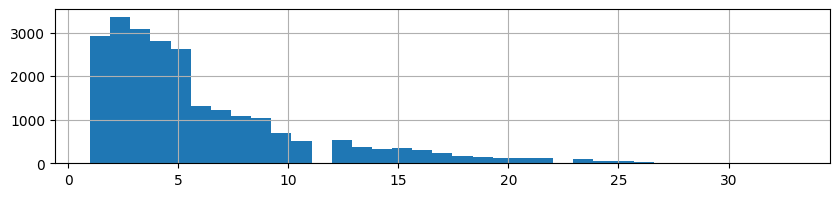

In [175]:
# определяем редкие значения в поле floor
data['floor'].hist(bins=35, figsize=(10,2));

Имеет смысл "сфокусироваться" на зданиях выше 20 этажей - их немного.

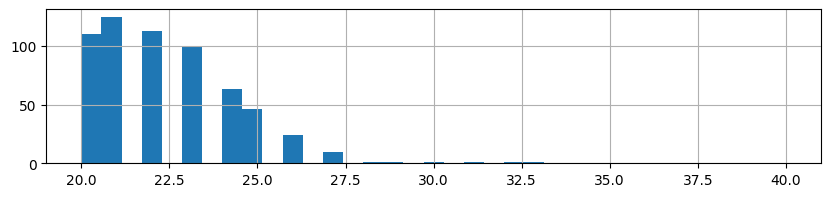

In [176]:
data['floor'].hist(bins=35, range=(20,40), figsize=(10,2));

Значения больше 27 этажа являются единичными. Удаляем эти значения-выбросы

In [177]:
data = data[data['floor'] <= 27]

### Общая площадь, площадь кухни, количество комнат, жилая площадь
Далее поработаем с пропусками в таких характиристиках жилья, как: общая площадь, площадь кухни, количество комнат

In [178]:
# количество комнат
data['rooms'].describe()

count    23691.000000
mean         2.070660
std          1.078508
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

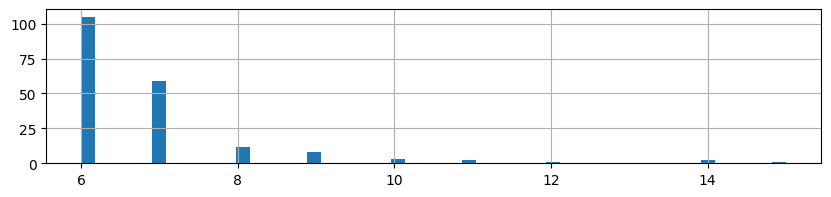

In [179]:
data.rooms.hist(bins=50, range=(6,15), figsize=(10,2));

Квартиры с больше, чем 8 комнатами - единичные, т.е. являются выбросами, можно удалять, как редкие.

In [180]:
# удалим выбросы по комнатам
data = data.query('rooms <= 8')

In [181]:
# общая площадь
data['total_area'].describe()

count    23672.000000
mean        60.126347
std         34.514959
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        631.200000
Name: total_area, dtype: float64

In [182]:
# жилая площадь
data['living_area'].describe()

count    21770.000000
mean        34.314766
std         21.344139
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        347.500000
Name: living_area, dtype: float64

Жилая площадь меньше 8 метров даже в комнате выглядит сомнительно. Похоже на ошибку.

In [183]:
# посмотрим, как соотносится общая и жилая площадь при жилой меньше 8
data.query('living_area < 8')['total_area'].value_counts()

22.0     1
139.0    1
52.0     1
31.0     1
33.0     1
23.0     1
41.0     1
77.6     1
Name: total_area, dtype: int64

Считаю эти данные неправдоподобными. Удалим их из ДС

In [184]:
data = data.loc[(data['living_area'] >= 8) | (data['living_area'].isna() == True)]

In [185]:
# можно заполнять пропуски
# информация по общей площади заполнена везде, пропусков нет
# посмотрим, какие значения есть в 'rooms', есть гипотеза,
# что значения 0 связаны с типом жилья "студия" и "свободная планировка"
print('Уникальные значения количества комнат:',\
      (data['rooms'].unique()))
print('Количество объектов с количеством комнат "0":',\
      len(data.query('rooms == 0')))
print('Количество объектов типа "студия" с количеством комнат "0":',\
      len(data.query('rooms == 0 & studio == True')))
print('Количество объектов типа "свободная планировка" с количеством комнат "0":',\
      len(data.query('rooms == 0 & open_plan == True')))

Уникальные значения количества комнат: [3 1 2 4 5 6 0 7 8]
Количество объектов с количеством комнат "0": 195
Количество объектов типа "студия" с количеством комнат "0": 136
Количество объектов типа "свободная планировка" с количеством комнат "0": 59


Гипотеза подтвердилась. Все объекты с количеством комнат 0, это студии объекты со свободной планировкой. Можно заполнить ячейки значением 1. К тому же их мало на фоне общей картины.

In [186]:
data.loc[data['rooms'] == 0, 'rooms'] = 1

Далее заполним пропуски по "жилой площади", здесь должна быть привязка к планировке и, например, количеству комнат. Для привязки к планировке, возьмем этажность.
Для этого можно категоризировать этажность зданий, дополнив таблицу стобцом "floor_type": 1-2 этажа - townhouse, 3-5 - low, 6-16 middle, больше 17 - skyscrap

In [187]:
def floor_type (row):
    if row <= 2:
        return 'townhouse'
    elif row <= 5:
        return 'low'
    elif row <= 16:
        return 'middle'
    else:
        return 'skyscrap'

# применяем функцию к ДС
data['floor_type'] = data['floors_total'].apply(floor_type)

# теперь по типу локации, этажности и соотношению с общей площадью, можно заполнить пропуски в жилой площади
# сначала в новом столбце найдем медианное соотношение жилой и общей площади для разных соотношений типа локации и этажности
for i in data['floor_type'].unique():
    for j in data['locality_type'].unique():
        data.loc[(data['locality_type'] == j) &\
                 (data['floor_type'] == i),\
                 'living_area_mean'] = \
                data.loc[(data['locality_type'] == j) &\
                         (data['floor_type'] == i), 'living_area'].median() / \
                data.loc[(data['locality_type'] == j) &\
                         (data['floor_type'] == i), 'total_area'].median()

# можно заполнить пропуски на основе соотношения
data['living_area'].fillna(data['total_area'] * data['living_area_mean'], inplace = True)

Площадь кухни

In [188]:
data['kitchen_area'].describe()

count    21389.000000
mean        10.549948
std          5.818945
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        107.000000
Name: kitchen_area, dtype: float64

Кухни < 5 кв.м. и  > 20 вызывают сомнения, посмотрим сколько этих значений

In [189]:
data.query('kitchen_area < 4')['total_area'].count()

29

In [190]:
data.query('kitchen_area > 100')['total_area'].count()

2

In [191]:
# удаляем "выбросы" объявления с площадью меньше 4
data = data.loc[(data['kitchen_area'] >= 4) | (data['kitchen_area'].isna() == True) ]

Площадь кухни зависит от планировки квартиры и общей площади, можно заполнить пропуски на основе медианных значений общей площади и этажности здания (как привязка к типу планировки). С другой стороны, в студиях площадь кухни = площади самой студии, они нераздельны, это же касается объектов "свободная планировка". 

In [192]:
# проверим, есть ли пропуски по площади кухни в студиях и свободных планировках
data.loc[(data['open_plan'] == True) |\
         (data['studio'] == True)]\
        ['kitchen_area'].unique()


array([nan])

Гипотеза подтверждена: для этих объектов площадь кухни не указана. Можно приравнять площадь кухни к жилой для таких объектов.
Для остальных также применим метод средней, как поступили с жилой площадью.

In [193]:
# приравняем площади жилой и кухни для студий и "свободных планировок"
data.loc[(data['studio'] == True) |\
         (data['open_plan'] == True), 'kitchen_area'].\
        fillna(data['living_area'], inplace = True)

# сначала в новом столбце найдем медианное соотношение площади кухни и общей площади для разных соотношений типа локации и этажности
for i in data['floor_type'].unique():
    for j in data['locality_type'].unique():
        data.loc[(data['locality_type'] == j) & (data['floor_type'] == i),\
                'kitchen_area_mean'] = \
                data.loc[(data['locality_type'] == j) &\
                         (data['floor_type'] == i), 'kitchen_area'].median() / \
                data.loc[(data['locality_type'] == j) &\
                         (data['floor_type'] == i), 'total_area'].median()
#
# можно заполнить пропуски на основе соотношения
data['kitchen_area'].fillna(data['total_area'] * data['kitchen_area_mean'], inplace = True)

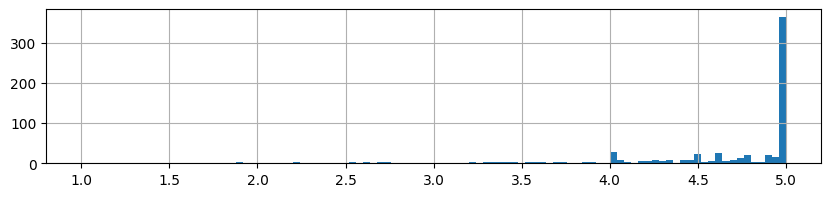

In [194]:
data.kitchen_area.hist(bins=100, range=(1,5), figsize=(10,2));

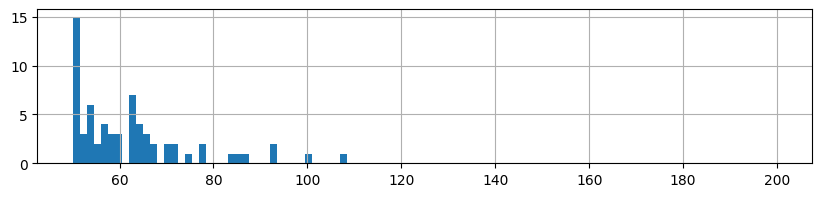

In [195]:
data.kitchen_area.hist(bins=100, range=(50,200), figsize=(10,2));

In [196]:
# удалим из ДС редкие квартиры с кухнями меньше 5 и больше 70 кв.м
data = data.loc[(data['kitchen_area'] >= 5) & (data['kitchen_area'] <= 70)]

In [197]:
# проведём проверку на корректность значений всех площадей, чтобы кухня не выходила за пределы балкона
len(data.query('(total_area * 0.9 - living_area + kitchen_area) < 0'))

0

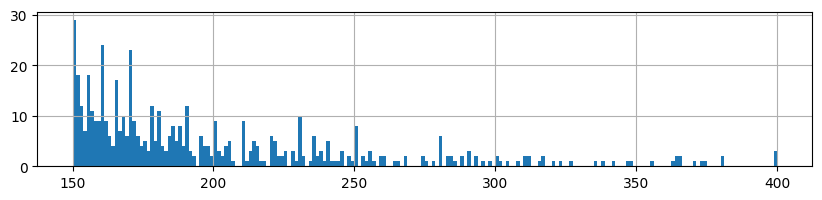

In [198]:
# определяем редкие значения в поле total_area
data.total_area.hist(bins=200, range=(150,400), figsize=(10,2));

Значения больше 250 кв.м общей площади кажутся уже "выбросами". Посмотрим, сколько таких объявлений.

In [199]:
data.query('total_area > 250')['total_area'].count()

96

Считаю, что можно эти данные удалить, как выбросы

In [200]:
data = data[data['total_area'] < 250]

### Высота полотка

In [201]:
data['ceiling_height'].describe()

count    14234.000000
mean         2.768510
std          1.270642
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

Среднее и медиана похожи на правду - около 2,7м, но крайние значения надо проанализировать

In [202]:
data.query('ceiling_height < 2.4')['ceiling_height'].value_counts()

2.00    11
2.30     3
1.75     1
2.34     1
2.25     1
1.20     1
1.00     1
Name: ceiling_height, dtype: int64

такие данные ошибочны, можно удалить их из ДС

In [203]:
# заполним пропуски медианой УДАЛЕНО!
#data['ceiling_height'].fillna(2.65, inplace = True)

In [204]:
# поглядим, что там - за "высокими" потолками
print(data.query('ceiling_height > 5')['ceiling_height'].value_counts())

27.0     8
25.0     7
8.0      3
32.0     2
14.0     1
22.6     1
5.3      1
6.0      1
8.3      1
5.8      1
10.3     1
5.5      1
20.0     1
26.0     1
27.5     1
24.0     1
100.0    1
Name: ceiling_height, dtype: int64


In [205]:
#исправляем ошибки ввода (похоже введённые цифры умножены на 10 - не было разделителя разрядов)
data.loc[(data['ceiling_height'] >= 24) & (data['ceiling_height'] <= 32), 'ceiling_height'] = data['ceiling_height'] / 10

# для заполнения высоты полотков также применим метод медианы по типу этажности

for i in data['floor_type'].unique():
    for j in data['locality_type'].unique():
        data.loc[(data['ceiling_height'].isna()) & (data['floor_type'] == i) & (data['locality_type'] == j), 'ceiling_height']\
        =  data.loc[(data['floor_type'] == i) & (data['locality_type'] == j), 'ceiling_height'].median()

# удаляем аномалии
data = data[(data['ceiling_height'] >= 2.4) & (data['ceiling_height'] <= 8)]

data['ceiling_height'].isna().sum()

0

### Дни экспозиции и дата размещения объявления

In [206]:
data['days_exposition'].describe()

count    20081.000000
mean       181.220009
std        219.652915
min          1.000000
25%         45.000000
50%         96.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

Объявления о продаже редких объектов или с очень высокой ценой могут висеть очень долго без спроса. Медиана 102 дня, 3 квартиль - 240. Можно удалить все объявления с экспозицией большей года, эти объекты и не хотели продавать. А квартиры в объявлениях без указания срока экспозиции, возможно, и не были проданы - заполнять такие пропуски, скорее всего, неправильно.

In [207]:
# оценим количество объявлений, висящих больше года
data.query('days_exposition > 365')['days_exposition'].value_counts()

388.0     23
385.0     20
383.0     18
370.0     18
468.0     17
          ..
1229.0     1
734.0      1
1111.0     1
1052.0     1
1572.0     1
Name: days_exposition, Length: 773, dtype: int64

Объявлений, экспонировавшихся больше года, достаточно много! Но это либо очень специфичное предложение, не делающее рынок, либо неадекватная цена. Оценим, как распределялись значения - построим гистограммы и боксплот.

In [208]:
# оценим количество объявлений, улетевших меньше, чем за 4 дня
# либо цена была очень "сладкая", либо объявление сняли раньше, тоже можно удалить
data.query('days_exposition < 4')['days_exposition'].value_counts()

3.0    155
2.0      2
1.0      1
Name: days_exposition, dtype: int64

(0.0, 510.0)

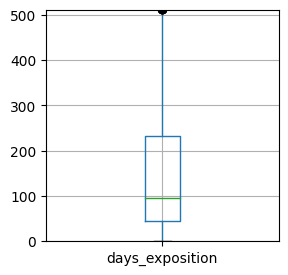

In [209]:
# построим боксплот для оценки распределения и нахождения граница "выбросов"
data.boxplot('days_exposition', figsize=(3,3))
plt.ylim(0, 510)

In [210]:
# удаляем те, что за пределами "усов" < 500
data = data[((data['days_exposition'] <= 500) &\
             (data['days_exposition'] >= 1)) |\
            (data['days_exposition'].isna())]
# сменить тип данных на целочисленный не получится, т.к. решено было оставить NaN в столбце

In [211]:
# преобразуем тип данных в формат ДАТА в столбце с датой первого дня экспозиции

data['first_day_exposition'] = \
    pd.to_datetime(data['first_day_exposition'], \
    format='%Y-%m-%dT%H:%M:%S') # 2019-03-07T00:00:00


### Цена объекта

In [212]:
# посмотрим на цену
data['last_price'].describe()

count    2.148500e+04
mean     6.086820e+06
std      6.726106e+06
min      1.219000e+04
25%      3.450000e+06
50%      4.600000e+06
75%      6.680000e+06
max      3.300000e+08
Name: last_price, dtype: float64

In [213]:
# преобразуем тип данных в целочисленный
data['last_price'] = data['last_price'].astype(int)

86

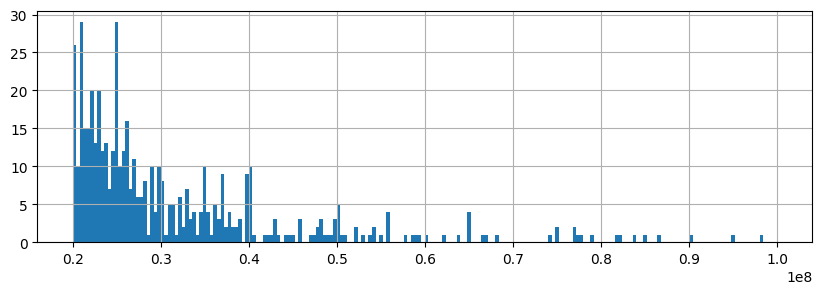

In [214]:
# определяем редкие значения в поле last_price
display(data.query('last_price > 40000000')['last_price'].count())
data.last_price.hist(bins=200, range=(20000000,100000000), figsize=(10,3));

Объявления с ценой больше 40млн являются очень редкими. Можно удалить из ДС, как выбросы

In [215]:
data = data[data['last_price'] <= 40000000]

### Выводы

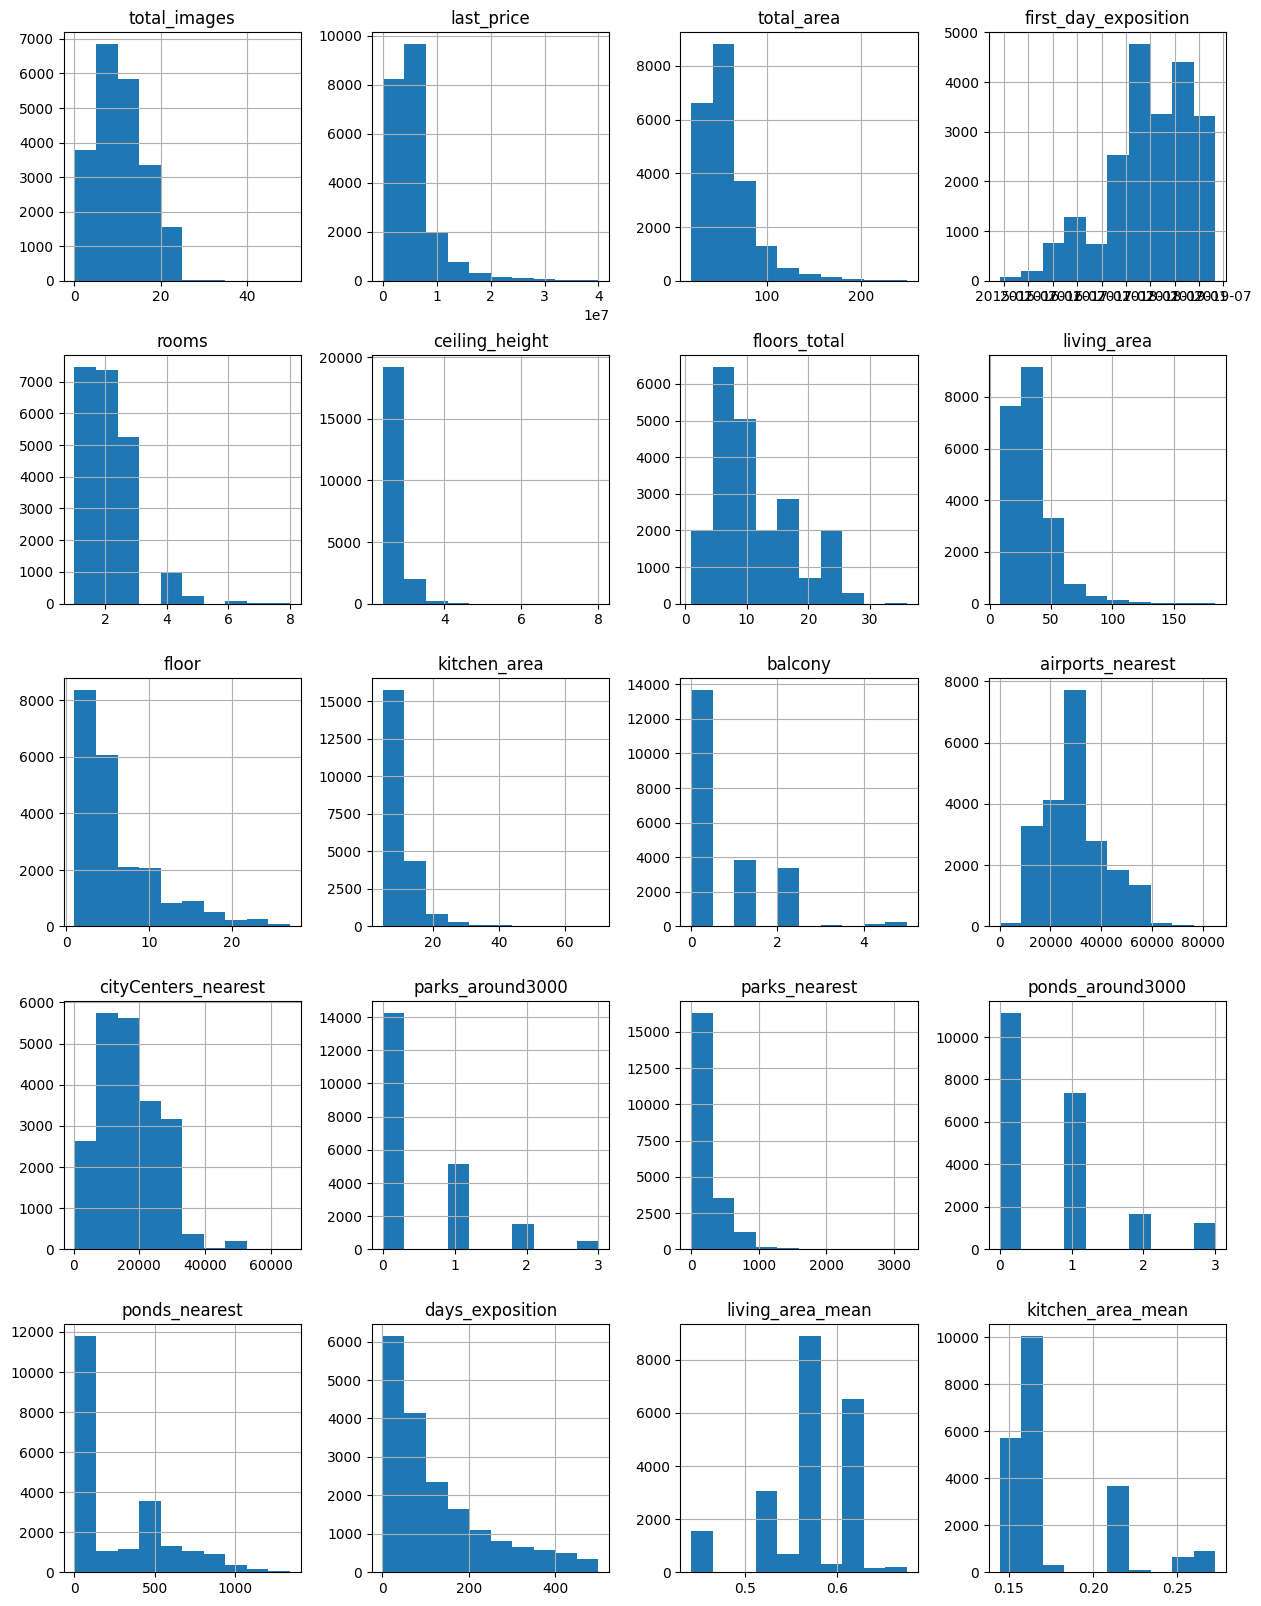

In [216]:
# вновь выведем общую информацию о ДС и построим гистрограммы
data.hist(figsize=(15, 20));

In [217]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21399 entries, 0 to 23698
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          21399 non-null  int64         
 1   last_price            21399 non-null  int32         
 2   total_area            21399 non-null  float64       
 3   first_day_exposition  21399 non-null  datetime64[ns]
 4   rooms                 21399 non-null  int64         
 5   ceiling_height        21399 non-null  float64       
 6   floors_total          21399 non-null  int32         
 7   living_area           21399 non-null  float64       
 8   floor                 21399 non-null  int64         
 9   is_apartment          21399 non-null  bool          
 10  studio                21399 non-null  bool          
 11  open_plan             21399 non-null  bool          
 12  kitchen_area          21399 non-null  float64       
 13  balcony         

Абсолютное большинство пропусков заполнено.<br>
Удалены ошибочные и нелогичные значения, которые искажали данные. При это удалено 7,6% записей.
Т.к. заполнение медианами, гистограммы сильно не изменились. Заметно изменение в датах - понятно (изменён тип), в парках и прудах - за счёт добавления информации по "городам и сёлам", в которых эти объекты рядом. Можно продолжать исследование.

## Посчитайте и добавьте в таблицу новые столбцы

### Цена квадратного метра

In [218]:
data['price_per_meter'] = data['last_price'] / data['total_area']

### День недели публикации объявления

In [219]:
data['week_day'] = data['first_day_exposition'].dt.weekday

### Месяц публикации

In [220]:
data['month'] = data['first_day_exposition'].dt.month

### Год публикации объявления

In [221]:
data['year'] = data['first_day_exposition'].dt.year

### Тип этажа

In [222]:
# убедимся, что значения столбца этаж не содержат отрицательных или 0 значений
len(data[data['floor'] <= 0])

0

In [223]:
data['floor_category'] = 'другой'
data.loc[(data['floor'] == data['floors_total']) &\
         (data['floor'] != 1),'floor_category'] = 'последний'
data.loc[data['floor'] == 1,'floor_category'] = 'первый'

### Расстояние до центра города в километрах

In [224]:
data['cityCenters_nearest_km'] = data['cityCenters_nearest'] / 1000
data['cityCenters_nearest_km'] = data['cityCenters_nearest_km'].astype(int)

In [225]:
# убедимся, что все столбцы встали на свои места
# и отражают адекватную информацию (хотя бы в 5 строках)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_type,floor_type,living_area_mean,kitchen_area_mean,price_per_meter,week_day,month,year,floor_category,cityCenters_nearest_km
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,столица,middle,0.567029,0.169982,120370.370370,3,3,2019,другой,16
1,7,3350000,40.4,2018-12-04,1,2.60,11,18.6,1,False,...,поселок,middle,0.548902,0.208583,82920.792079,1,12,2018,первый,18
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,столица,middle,0.567029,0.169982,100000.000000,1,6,2018,другой,8
5,10,2890000,30.4,2018-09-10,1,2.60,12,14.4,5,False,...,поселок,middle,0.548902,0.208583,95065.789474,0,9,2018,другой,21
6,6,3700000,37.3,2017-11-02,1,2.70,26,10.6,6,False,...,поселок,skyscrap,0.445000,0.272500,99195.710456,3,11,2017,другой,19


## Исследовательский анализ данных

### Изучение параметров объектов

#### общая площадь и жилая площадь

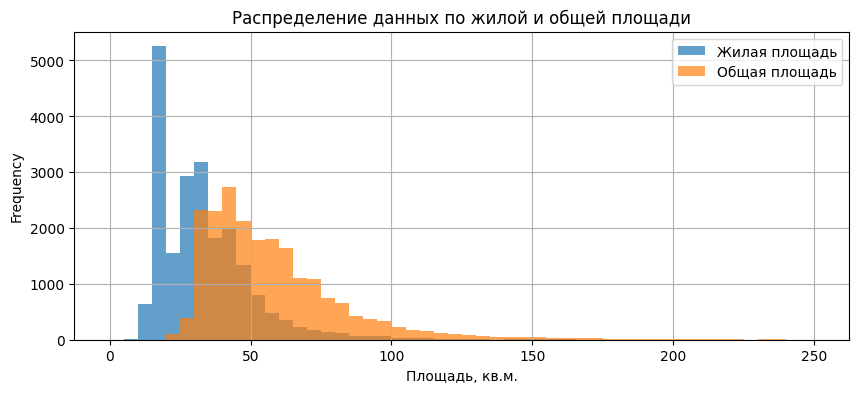

In [226]:
ax = data.plot(
    kind='hist',
    y='living_area',
    range=(0, 250),
    ylabel='Количество объявлений',
    bins=50,
    alpha=0.7,
    label='Жилая площадь',
    figsize=(10,4)
)
data.plot(
    kind='hist',
    y='total_area',
    range=(0, 250),
    bins=50,
    alpha=0.7,
    label='Общая площадь',
    title='Распределение данных по жилой и общей площади',
    ylabel='Количество объявлений',
    ax=ax,
    grid=True,
    legend=True,
    figsize=(10,4)
);
plt.xlabel('Площадь, кв.м.')
plt.show()

По обоим показателям видим нормальное распределение. Абсолютное большинство объявлений содержит объекты с общей площадью от 25 до 75 кв.м. Жилая площадь, ожидаемо, меньше общей, по этому показателю основное количество объявлений до 50 кв.м.

#### площадь кухни

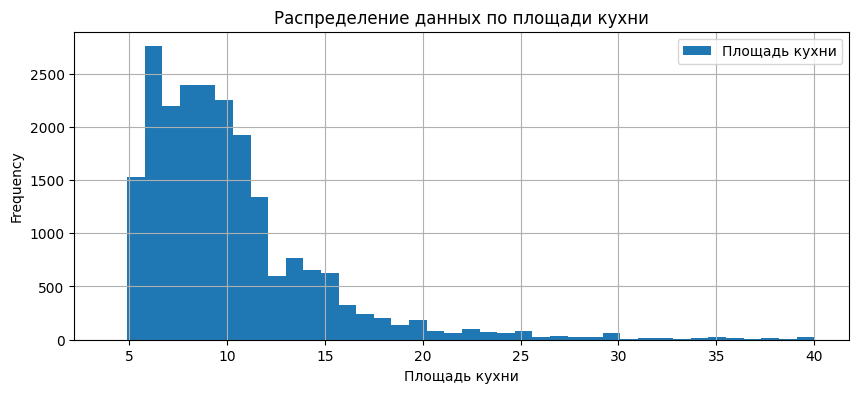

In [227]:
data.plot(
    kind='hist',
    y='kitchen_area',
    range=(4, 40),
    bins=40,
    label='Площадь кухни',
    title='Распределение данных по площади кухни',
    ylabel='Количество объявлений',
    grid=True,
    legend=True,
    figsize=(10,4)
);
plt.xlabel('Площадь кухни')
plt.show()

Всё, как в жизни: основной объём объектов в "человеческих" 6-12 кв.м. Также видим нормально распределение.

#### цена объекта

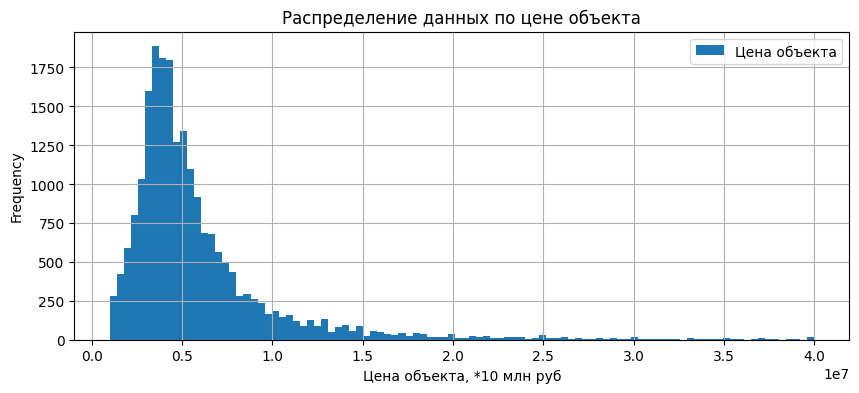

In [228]:
data.plot(
    kind='hist',
    y='last_price',
    range=(1000000, 40000000),
    bins=100,
    label='Цена объекта',
    title='Распределение данных по цене объекта',
    ylabel='Количество объявлений',
    grid=True,
    legend=True,
    figsize=(10,4)
);
plt.xlabel('Цена объекта, *10 млн руб')
plt.show()

Нормальное распределение. Основной объём объявлений в диапазоне от 2,2 млн до 7 млн

#### количество комнат

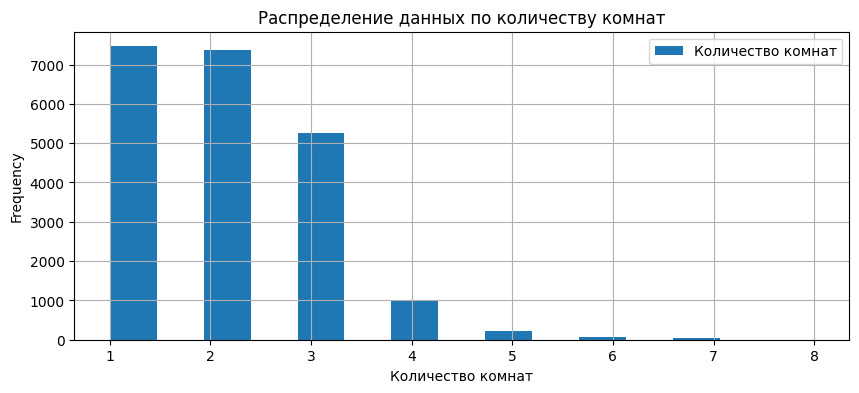

In [229]:
data.plot(
    kind='hist',
    y='rooms',
    range=(1, 8),
    bins=15,
    label='Количество комнат',
    title='Распределение данных по количеству комнат',
    ylabel='Количество объявлений',
    grid=True,
    legend=True,
    figsize=(10,4)
);
plt.xlabel('Количество комнат')
plt.show()

Ожидаемо, в большиство объявлений 1-2 комнаты, реже - 3 или 4, совсем мало 5-6, остальные варианты - теряются. Нормальное распределение.

#### высота потолков

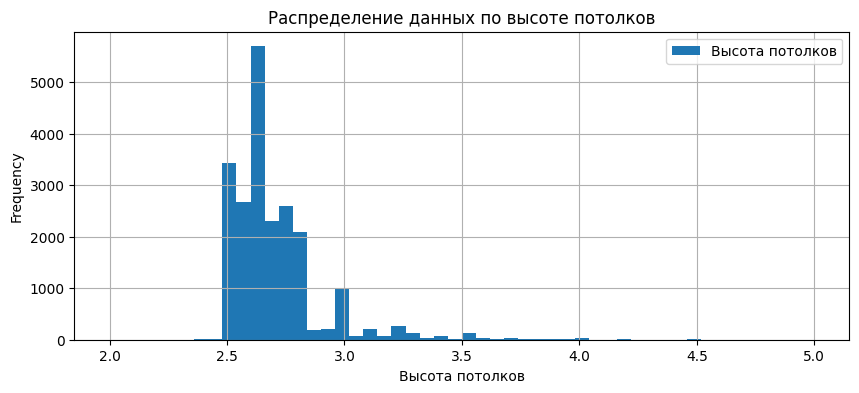

In [230]:
data.plot(
    kind='hist',
    y='ceiling_height',
    range=(2, 5),
    bins=50,
    label='Высота потолков',
    title='Распределение данных по высоте потолков',
    ylabel='Количество объявлений',
    grid=True,
    legend=True,
    figsize=(10,4)
);
plt.xlabel('Высота потолков')
plt.show()

В обычном жилье высота потолка 2,5 - 2,7м. Это подтверждает и график. Так же виден пик в районе 3-х метров - вероятно, старый жил. фонд. Нормальное распределение.

#### этаж жилья

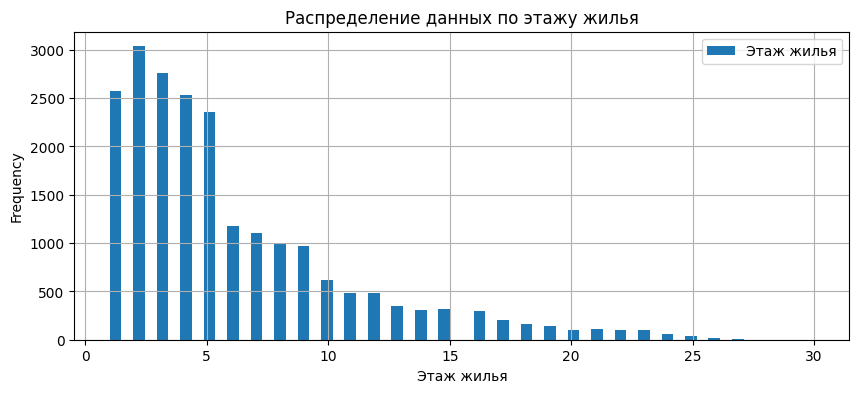

In [231]:
data.plot(
    kind='hist',
    y='floor',
    range=(1, 30),
    bins=60,
    label='Этаж жилья',
    title='Распределение данных по этажу жилья',
    ylabel='Количество объявлений',
    grid=True,
    legend=True,
    figsize=(10,4)
);
plt.xlabel('Этаж жилья')
plt.show()

Жилой фонд в Лен.области обновляется не быстро (как и везде). Основной объём объявлений с этажами до 5, очевидно, это связано с преобладающим типом этажности (старые и невысокие дома). Реже встречаются объявления с этажом до 10, выше - гораздо реже. Высотного жилья мало и оно мало продаётся.

#### тип этажа квартиры («первый», «последний», «другой»)

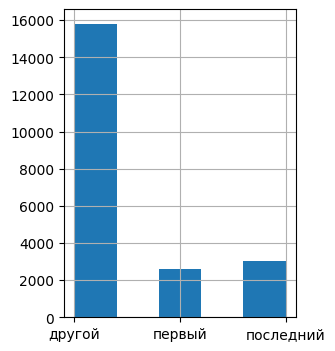

In [232]:
data['floor_category'].hist(bins=5, figsize=(3,4));

Объявления с первым и последним этажом встречаются примерно с одинаковой частотой 1 из 3-4 объявлений.

#### общее количество этажей в доме

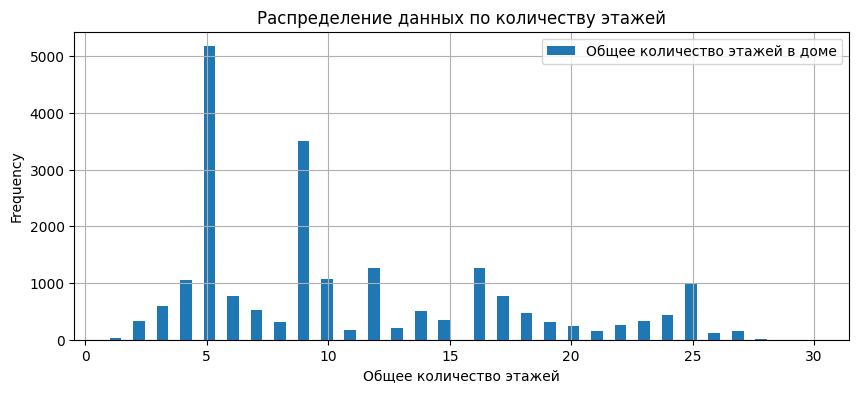

In [233]:
data.plot(
    kind='hist',
    y='floors_total',
    range=(1, 30),
    bins=60,
    label='Общее количество этажей в доме',
    title='Распределение данных по количеству этажей',
    ylabel='Количество объявлений',
    grid=True,
    legend=True,
    figsize=(10,4)
);
plt.xlabel('Общее количество этажей')
plt.show() 

Распределение имеет несколько пиков. Это связано с преобладанием типовой застройки: наиболее часто встречаются дома 5, 9, 12 и 16 этажей. Виден "поднимающийся пик" нового жилья 24-25 этажей.

#### расстояние до центра города в метрах

In [234]:
# вычисляем значения-заглушки, чтобы не портили график
dummy = data['cityCenters_nearest'].value_counts().head(2).index.to_list()

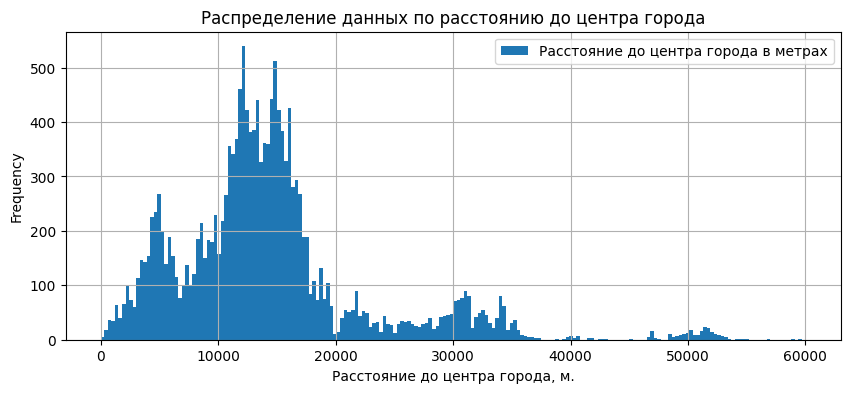

In [235]:
(
    data.query('cityCenters_nearest not in @dummy')
    .plot(
    kind='hist',
    y='cityCenters_nearest',
    range=(1, 60000),
    bins=200,
    label='Расстояние до центра города в метрах',
    title='Распределение данных по расстоянию до центра города',
    ylabel='Количество объявлений',
    grid=True,
    legend=True,
    figsize=(10,4))
);
plt.xlabel('Расстояние до центра города, м.')
plt.show() 

Основная масса объявление входит в диапазон распределения с пиками от 11км до 17км, ещё заметен пик в районе 5км, также заметны небольшие пики в районе 30 и 50 км. Думаю, это объявления из перифирийных центров городской агломерации СПб, в которых указано расстояние до облцентра. Большой пик в середине (12-14км) можно объяснить большим количеством объявлений в СПб. Из выборки убраны значения-заглушки.

#### расстояние до ближайшего аэропорта

In [236]:
# вычисляем значения-заглушки, чтобы не портили график
dummy = data['airports_nearest'].value_counts().head(2).index.to_list()

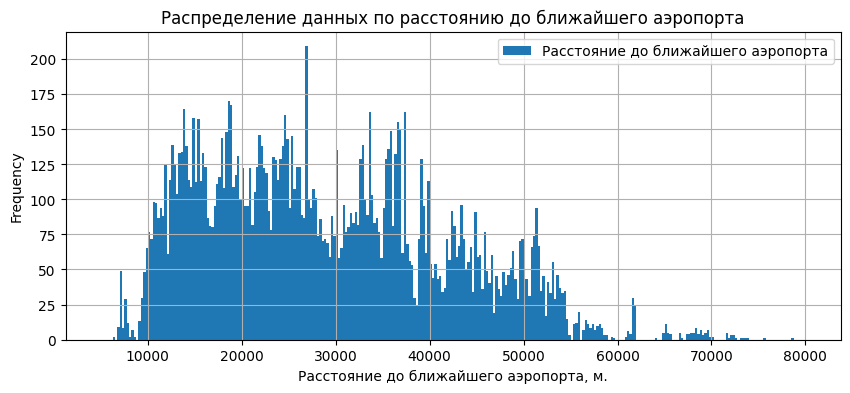

In [237]:
data.query('airports_nearest not in @dummy').plot(
    kind='hist',
    y='airports_nearest',
    range=(5000, 80000),
    bins=300,
    label='Расстояние до ближайшего аэропорта',
    title='Распределение данных по расстоянию до ближайшего аэропорта',
    ylabel='Количество объявлений',
    grid=True,
    legend=True,
    figsize=(10,4)
);
plt.xlabel('Расстояние до ближайшего аэропорта, м.')
plt.show() 

Гугл сообщает, что в Лен.области 3 аэропорта, но главный - 1, это Пулково. До какого из них измерено расстояние сказать трудно. Но, очевидно, что большинство измеряло до Пулково, основная агломерация, и количество объявлений на продажу сосредоточено там. По мере удаления от аэропорта, удаляемся от СПб, уменьшается и количество объявлений.

#### расстояние до ближайшего парка

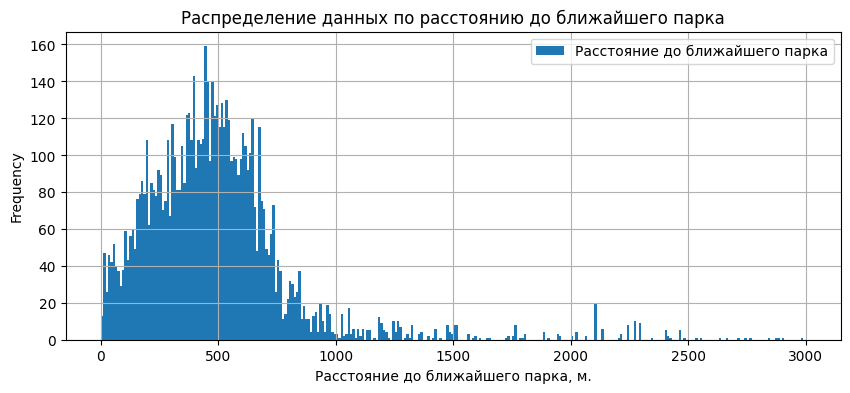

In [238]:
data.plot(
    kind='hist',
    y='parks_nearest',
    range=(1, 3000),
    bins=300,
    label='Расстояние до ближайшего парка',
    title='Распределение данных по расстоянию до ближайшего парка',
    ylabel='Количество объявлений',
    grid=True,
    legend=True,
    figsize=(10,4)
);
plt.xlabel('Расстояние до ближайшего парка, м.')
plt.show() 

Зеленая зона рядом с домом в мегаполисе очень важна, особенно, если в шаговой доступности (500-700м). Большиство объявлений именно такие. Нормальное распределение.

#### день и месяц публикации объявления

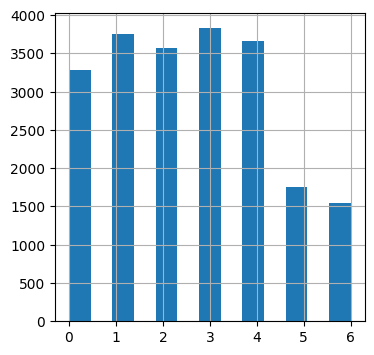

In [239]:
data['week_day'].hist(bins=13, figsize=(4,4));

Заметно, что большинство объявлений размещено в рабочие дни. В выходные дни люди предпочитают отдыхать.
Странно, ведь именно в выходной день можно без отвлечений заняться куплей-продажей недвижимости ;)

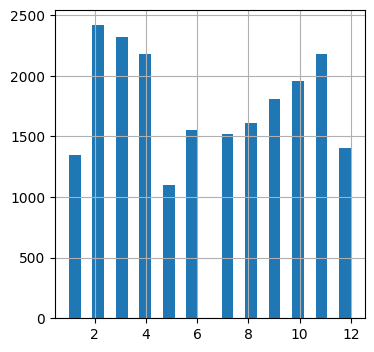

In [240]:
data['month'].hist(bins=24, figsize=(4,4));

Похожая тенденция. Отмечается спад в "праздничные" месяцы - январь и май. Всё лето количетсво объявлений разгоняется и достигает пика в самом деловом сезоне сентябрь-ноябрь и февраль-март. Это можно использовать при поиске вариантов покупки, чтобы найти больше предложений на рынке.

### Как быстро продавались квартиры

При заполнении пропусков и удалении аномалий, мы исключили из ДС объявления со сроком экспозиции больше 500 дней.<br>Посмотрим, как распределились сроки экспозиции в этих рамках.

In [241]:
# вычисляем значения-заглушки, чтобы не портили график
dummy = data['days_exposition'].value_counts().head(5).index.to_list()

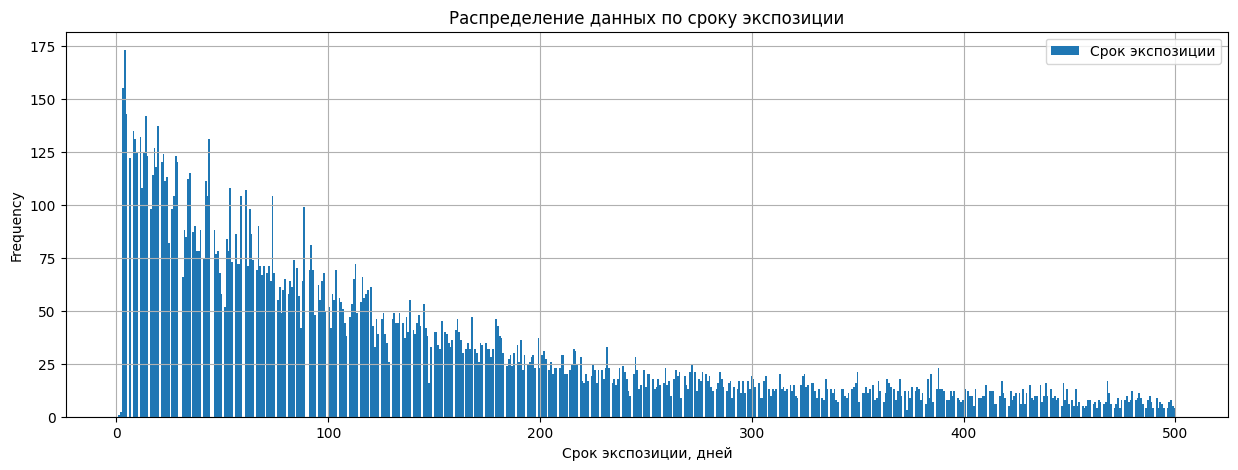

In [242]:
data.query('days_exposition not in @dummy').plot(
    kind='hist',
    y='days_exposition',
    range=(1, 500),
    bins=600,
    label='Срок экспозиции',
    title='Распределение данных по сроку экспозиции',
    ylabel='Количество объявлений',
    grid=True,
    legend=True,
    figsize=(15,5)
);
plt.xlabel('Срок экспозиции, дней')
plt.show() 

<AxesSubplot:>

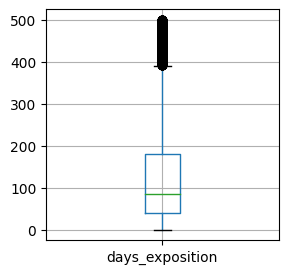

In [243]:
# также построим "ящик с усами"
data.boxplot('days_exposition', figsize=(3,3))

In [244]:
data['days_exposition'].describe()

count    18310.000000
mean       127.315019
std        119.210232
min          1.000000
25%         41.000000
50%         85.000000
75%        181.000000
max        500.000000
Name: days_exposition, dtype: float64

Средняя величина и медиана видны на выводе метода describe(), и равны, соответственно, 127,32 и 85 дням.
Основной диапазон данных по экспозиции находится между 1 днём и, примерно, 390 днями. Самая же основная масса находится между 1 и 3 квартилем, т.е, чаще всего квартиры экспонировались от 41 до 181 дней.<br><br> Не забудем оговорку, что в таблице остались данные без информации об экспонировании (около 3 тыс. объектов) - они не попали в этот расчёт.

### Факторы, которые больше всего влияют на общую (полную) стоимость объекта

#### Влияние на стоимость общей площади
<br>
Построим график зависимости<br>
Также рассчитаем коэффициент корреляции Пирсона

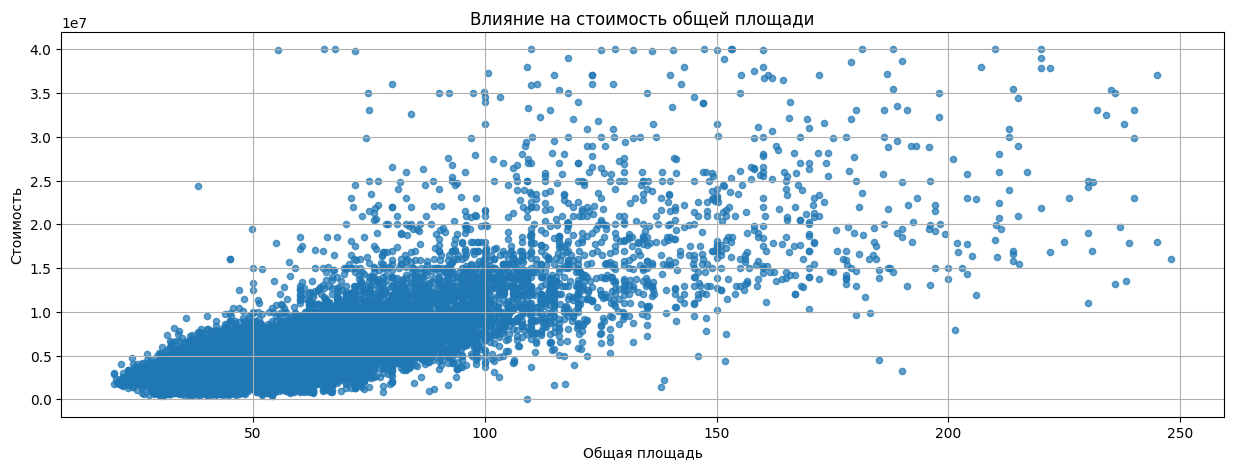

In [245]:
#data.query('total_area < 400').pivot_table\
#(index='total_area', values='last_price', aggfunc='median').plot(kind='scatter', grid=True, figsize=(8, 3))
(
    data.plot(
    x='total_area',
    y='last_price',
    kind='scatter',
    figsize=(15,5),
    grid=True,
    alpha=0.7,
    title='Влияние на стоимость общей площади',
    ylabel='Стоимость',
    xlabel='Общая площадь')
);

In [246]:
data['last_price'].corr(data['total_area'])

0.7811101758364283

График зависимости стоимости от общей площади показывает выраженную зависимость: при росте общей площади жилья - растёт и цена. Это подтверждает рассчитанный коэффициент Пирсона, равный без малого 0,8 - очень высокая корреляция. С ростом площади больше 100кв.м появляется много единичных выбросов с кратным ростом цены, думаю, что при такой большой площади на цену сильнее влияют какие-то дополнительные факторы (место, ЖК, ремонт и т.п.) 

#### Влияние на стоимость жилой площади
<br>
Построим график зависимости<br>
Также рассчитаем коэффициент корреляции Пирсона

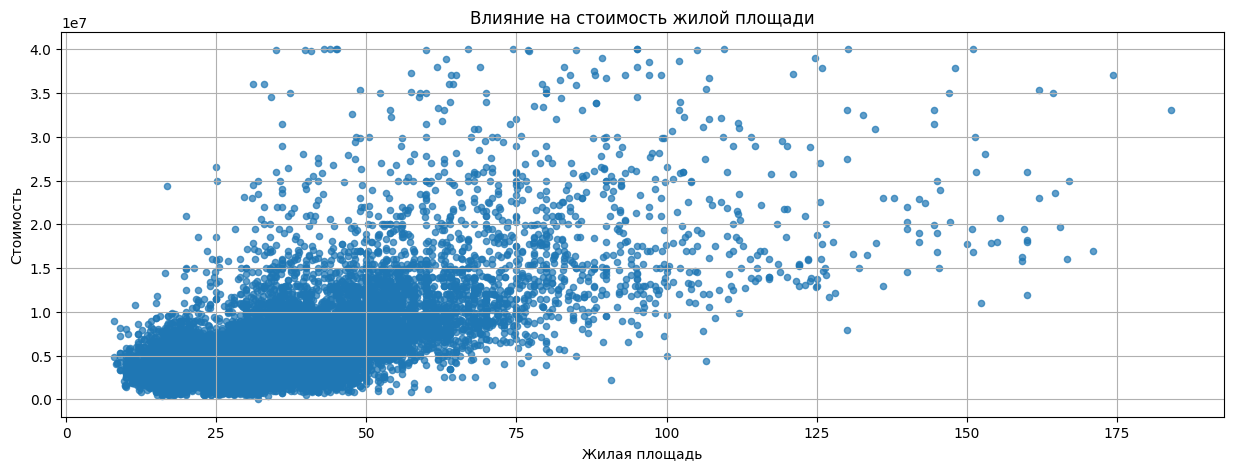

In [247]:
#data.query('living_area <200').pivot_table\
#(index='living_area', values='last_price', aggfunc='median').plot(grid=True, figsize=(8, 3)) 
(
    data.plot(
    x='living_area',
    y='last_price',
    kind='scatter',
    figsize=(15,5),
    grid=True,
    alpha=0.7,
    title='Влияние на стоимость жилой площади',
    ylabel='Стоимость',
    xlabel='Жилая площадь')
);

In [248]:
data['last_price'].corr(data['living_area'])


0.6779652247855027

График зависимости стоимости от жилой площади отчасти повторяет предыдущий видна зависимость, но несколько менее выраженная: при росте жилой площади жилья - растёт и цена. Коэффициент Пирсона, равен 0,68 - тоже высокая корреляция.

#### Влияние на стоимость площади кухни
<br>
Построим график зависимости<br>
Рассчитаем коэффициент корреляции Пирсона

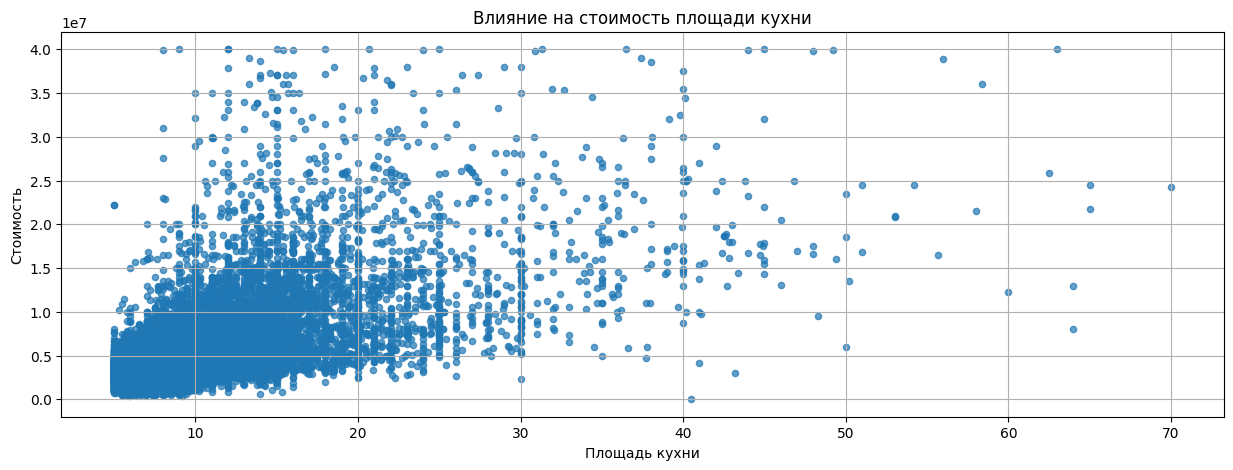

In [249]:
#data.query('kitchen_area < 60').pivot_table\
#(index='kitchen_area', values='last_price', aggfunc='median').plot(grid=True, figsize=(8, 3)) 
(
    data.plot(
    x='kitchen_area',
    y='last_price',
    kind='scatter',
    figsize=(15,5),
    grid=True,
    alpha=0.7,
    title='Влияние на стоимость площади кухни',
    ylabel='Стоимость',
    xlabel='Площадь кухни')
);

In [250]:
data['last_price'].corr(data['kitchen_area'])

0.6049502604495048

Коэфициент Пирсона показывает наличие явной взаимосвязи. На графике она тоже прослеживается: больше кухня - больше стоимость. Но большие кухни бывают и в не очень больших (дорогих) квартирах, поэтому связь менее выраженная.

#### Влияние на стоимость количества комнат
<br>
Построим график зависимости на основе сводной таблицы<br>
Рассчитаем коэффициент корреляции Пирсона

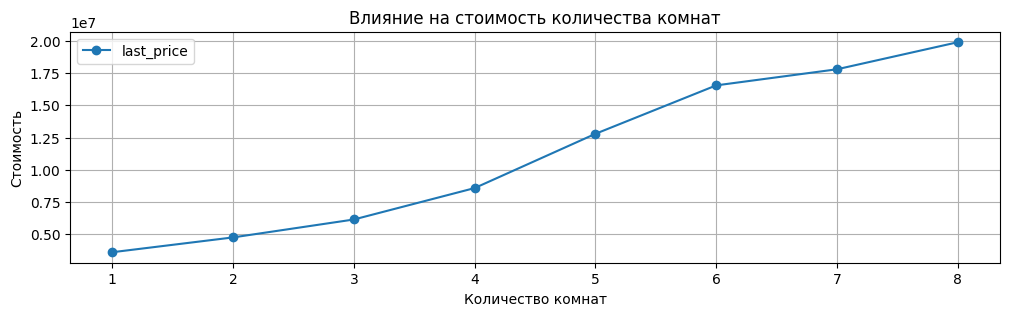

In [251]:
(
    data.pivot_table
    (index='rooms', values='last_price', aggfunc='median')
    .plot(
        grid=True,
        style='o-', 
        figsize=(12, 3),
        title='Влияние на стоимость количества комнат',
        ylabel='Стоимость',
        xlabel='Количество комнат')
);

In [252]:
data['last_price'].corr(data['rooms'])

0.4938274413672022

Вот он - "оптический обман зрения"! На графике ясно видно сильная корреляция, а Пирсон утверждает, что не такая уж и сильная, меньше 0,5! Думаю дело в дискретности показателя "rooms". График строится на средних показателях сводной таблицы, а коэффициент по всем данным ДС.

#### Влияние на стоимость типа этажа
<br>
Построим график зависимости на основе сводной таблицы<br>
<s>Рассчитаем коэффициент корреляции Пирсона</s>

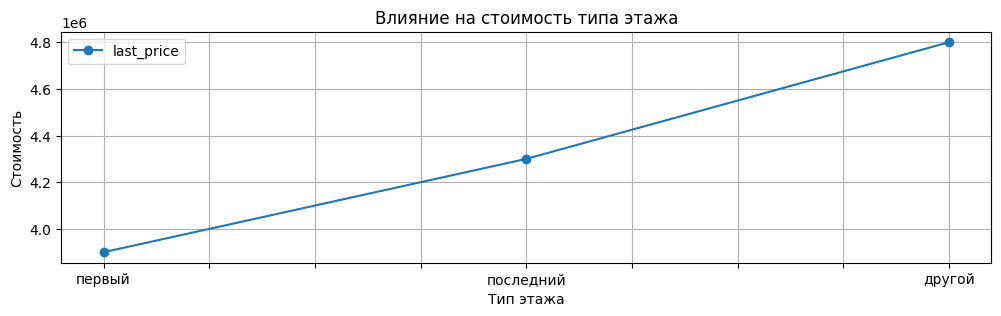

In [253]:
(
    data.pivot_table
    (index='floor_category', values='last_price', aggfunc='median')
    .sort_values(by = 'last_price')
    .plot(
        grid=True,
        style='o-', 
        figsize=(12, 3),
        title='Влияние на стоимость типа этажа',
        ylabel='Стоимость',
        xlabel='Тип этажа')
);

Оценивая зависимость стоимости от категории этажа, придётся довериться зрительному восприятию. Коэффициент не посчитать. Видно, что самыми "дешёвыми" вариантами являются квартиры с окошками с видом на прохожих (1 этаж), соседство с Карлсоном оценивается чуть дороже. Ну, а больше всего ценится "золотая середина"!<br> Данные "бьются" с жизненным опытом, всё правда...<br>Хотя необходимо отметить, что значения стоимости не уходят в 0, если жильё на первом этаже! Просто оно стоит относительно дешевле! Об этом говорит минимальное значение шкалы Стоимость.

#### Влияние на стоимость дня недели экспонирования
<br>
Построим график зависимости на основе сводной таблицы<br>
<s>Рассчитаем коэффициент корреляции Пирсона</s>

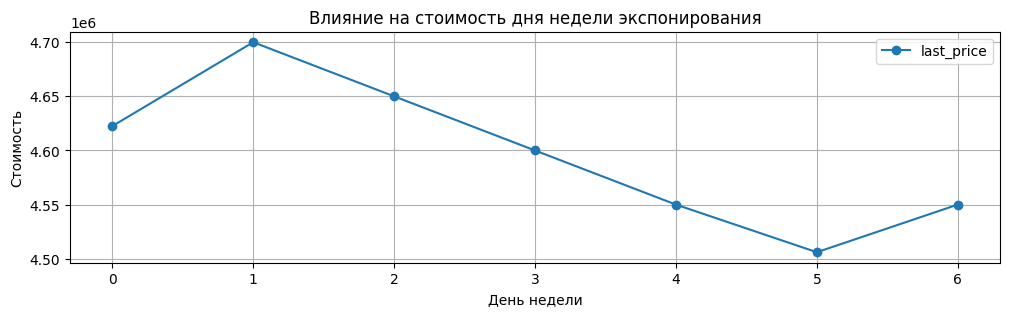

In [254]:
(
    data.pivot_table
    (index='week_day', values='last_price', aggfunc='median')
    .plot(
        grid=True,
        style='o-', 
        figsize=(12, 3),
        title='Влияние на стоимость дня недели экспонирования',
        ylabel='Стоимость',
        xlabel='День недели')
);

Несмотря на "крутой" спуск графика, по левой шкале видно, что зависимости стоимости от дня недели почти нет. Разница между максимальным и минимальным значением на шкале 3%.

#### Влияние на стоимость месяца экспонирования
<br>
Построим график зависимости на основе сводной таблицы<br>
<s>Рассчитаем коэффициент корреляции Пирсона</s>

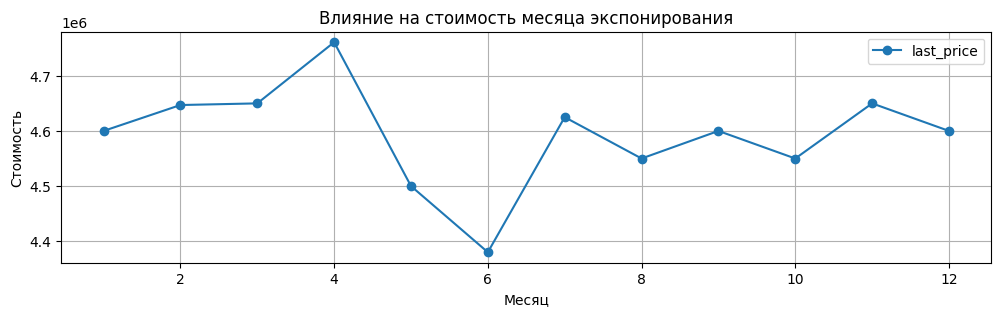

In [255]:
(
    data.pivot_table
    (index='month', values='last_price', aggfunc='median')
    .plot(
        grid=True,
        style='o-', 
        figsize=(12, 3),
        title='Влияние на стоимость месяца экспонирования',
        ylabel='Стоимость',
        xlabel='Месяц')
);

Та же история, что и с днём недели. Зависимости стоимости от месяца размещения - нет.

#### Влияние на стоимость года размещения
<br>
Построим график зависимости на основе сводной таблицы<br>
Рассчитаем коэффициент корреляции Пирсона

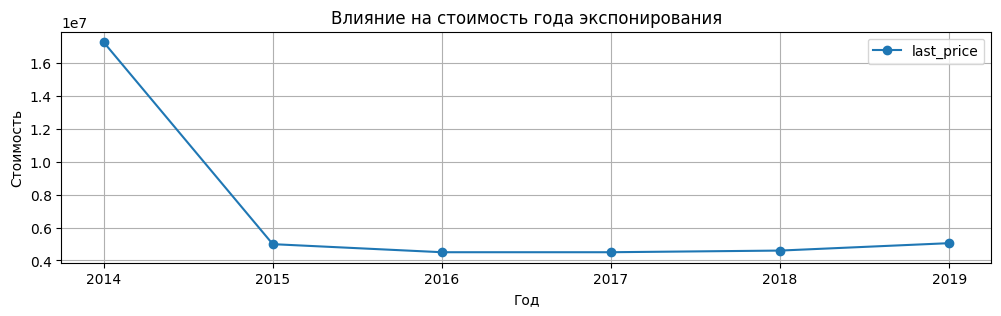

In [256]:
(
    data.pivot_table
    (index='year', values='last_price', aggfunc='median')
    .plot(
        grid=True,
        style='o-', 
        figsize=(12, 3),
        title='Влияние на стоимость года экспонирования',
        ylabel='Стоимость',
        xlabel='Год')
);

In [257]:
data['last_price'].corr(data['year'])

-0.007547212201780728

А здесь зависимость обратная, хоть и незначительная, о чём говорит Пирсон. Попробуем разобраться, почему год оказывает влияние на цену, судя по данным ДС.

In [258]:
# оценим другие показатели стоимостей объектов по годам
(
    data.pivot_table
    (index='year',
     values='last_price',
     aggfunc=['median', 'mean', 'count', 'max', 'min'])
)

,median,mean,count,max,min
,last_price,last_price,last_price,last_price,last_price
year,,,,,
2014,17250000,1.521024e+07,17,29999000,2300000
2015,4990000,6.592201e+06,509,40000000,650000
2016,4500000,5.897093e+06,2094,39900000,580000
2017,4500000,5.757859e+06,7661,40000000,450000
2018,4600000,5.675630e+06,8313,40000000,430000
2019,5050000,6.172824e+06,2805,39900000,12190


Заметно, что в ДС за 2014 очень мало объявлений, и средние показатели и медиана - скорей всего не показывают всей правды, а смещены в сторону высоких цифр. В 2015 году ситуация чуть лучше, выборка более богата - и сразу высокие цены размываются массой объявлений с недорогими объектами (показатель min заметно снижен, как и средняя).

### Cредняя цена квадратного метра в 10 населённых пунктах с наибольшим числом объявлений

,object_count,meter_price_mean
locality_name,,
Санкт-Петербург,"14,139.00","111,298.45"
поселок Мурино,549.00,"86,200.00"
деревня Кудрово,434.00,"95,551.51"
поселок Шушары,413.00,"78,377.91"
Всеволожск,359.00,"68,841.49"
Пушкин,335.00,"103,137.55"
Колпино,319.00,"75,171.12"
поселок Парголово,312.00,"89,914.89"
Гатчина,278.00,"68,892.41"


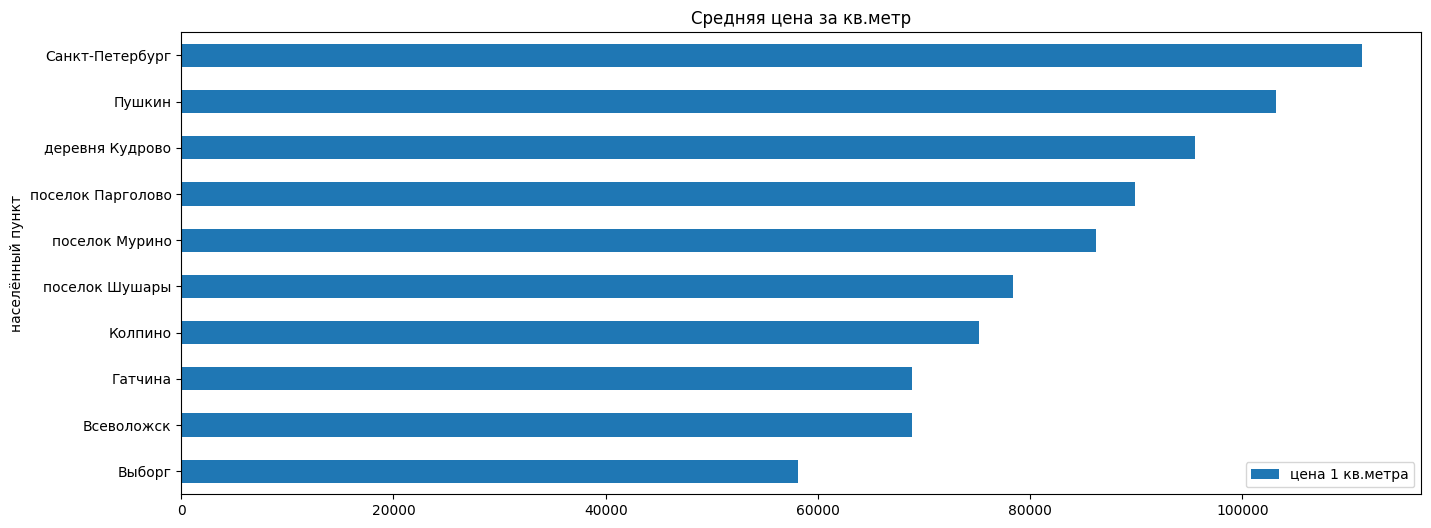

In [259]:
# построим сводную таблицу с максимальным числом объявлений
data10 = data.pivot_table(index='locality_name', values='price_per_meter', aggfunc=['count', 'mean'])

# Убиваем мультииндекс
data10.columns = ['object_count', 'meter_price_mean']

#таблица
data10 = data10.sort_values(by='object_count', ascending=False).head(10)
display(data10.style.format("{:,.2f}"))

# строим график
(
    data10
    .sort_values(by = 'meter_price_mean', ascending = True)
    .plot(kind='barh',
        figsize=(16,6), title='Cредняя цена за кв.метр',
        y='meter_price_mean',
        xlabel='населённый пункт',
        ylabel='цена 1 кв.метра',
        label='цена 1 кв.метра')
);

На графике отображены населённые пункты с максимальным количеством объявлений и средней ценой квадратного метра. Лидер, понятно - СПб, далее идут спутники (спальные районы) и другие города области. Наибольшая цена - в столице региона, наименьшая - во Всеволжске.

### Средняя цена километра до центра в Санкт-Петербурге

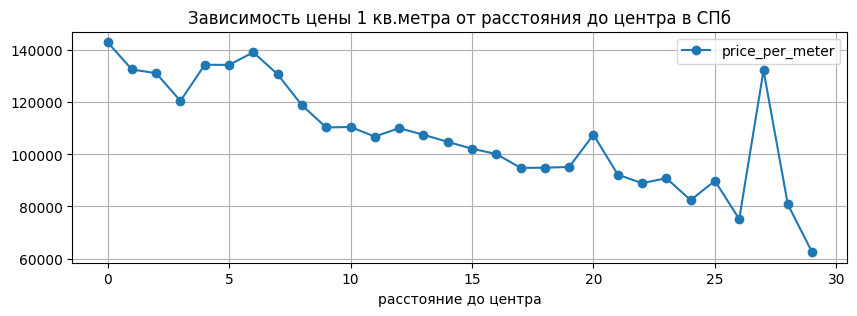

In [260]:
data_spb = \
    data.query('locality_type == "столица"').\
    pivot_table(index='cityCenters_nearest_km', \
            values='price_per_meter', aggfunc='mean')

(
    data_spb
    .plot(
        grid=True, 
        style='o-', 
        figsize=(10, 3), 
        title='Зависимость цены 1 кв.метра от расстояния до центра в СПб', 
        xlabel='расстояние до центра') 
);

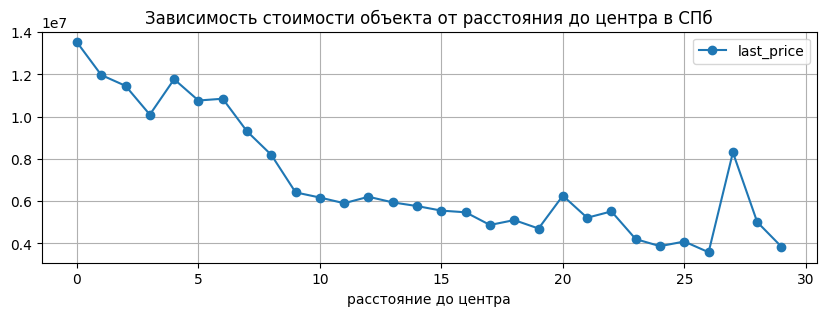

In [261]:
data_spb2 = \
    data.query('locality_type == "столица"').\
    pivot_table(index='cityCenters_nearest_km', \
            values='last_price', aggfunc='mean')

(
    data_spb2
    .plot(
        grid=True, 
        style='o-', 
        figsize=(10, 3), 
        title='Зависимость стоимости объекта от расстояния до центра в СПб', 
        xlabel='расстояние до центра') 
);

In [262]:
(
    data
    .query('cityCenters_nearest_km in [25, 26, 27, 28, 29] & locality_type == "столица"')
    .pivot_table
        (
        index='cityCenters_nearest_km',
        aggfunc=['count', 'median'],
        values=['total_area',
                'floors_total',
                'rooms',
                'parks_nearest',
                'parks_around3000',
                'ponds_nearest',
                'ceiling_height',
                'days_exposition',
                'last_price'
               ]
        )
)

count                                          \
                       ceiling_height days_exposition floors_total last_price   
cityCenters_nearest_km                                                          
25                                 68              67           68         68   
26                                  3               3            3          3   
27                                  2               2            2          2   
28                                  8               8            8          8   
29                                  3               2            3          3   

                                                                           \
                       parks_around3000 parks_nearest ponds_nearest rooms   
cityCenters_nearest_km                                                      
25                                   68            68            68    68   
26                                    3             3             3     3   
27                                    2             2             2     2   
28                                    8             8             8     8   
29                                    3             3             3     3   

                                          median                               \
                       total_area ceiling_height days_exposition floors_total   
cityCenters_nearest_km                                                          
25                             68          2.750           114.0          5.0   
26                              3          3.000            45.0          3.0   
27                              2          3.065           153.0          3.5   
28                              8          2.800           258.5          5.0   
29                              3          3.500            97.5          3.0   

                                                                  \
                       last_price parks_around3000 parks_nearest   
cityCenters_nearest_km                                             
25                        3455000              1.0         251.0   
26                        3975000              0.0           0.0   
27                        8300000              0.5         748.0   
28                        4920000              0.0           0.0   
29                        4200000              0.0           0.0   

                                                       
                       ponds_nearest rooms total_area  
cityCenters_nearest_km                                 
25                             471.0   1.0       38.1  
26                               0.0   1.0       46.0  
27                               0.0   1.5       53.0  
28                               0.0   2.5       63.0  
29                               0.0   2.0       56.8

Цена недвижимости на 27-км от центра СПб существенно выбивается за счёт всего 2 предложений! И в их характеристиках фигурирует несколько парков, т.е. это жильё в экологически привлекательной зоне. Высокие потолки говорят о старой застройке.

In [263]:
# так как, судя по графику, зависимость практически линейная,
#найдём среднюю цену километра как
# разность между максимальной и минимальной ценой метра, отнесённой к дальности самого удалённого объекта

delta_price_mean = \
    int((data_spb['price_per_meter'].max() -\
                    data_spb['price_per_meter'].min()) / \
                    data_spb.index.max())
delta_price_mean2 = \
    int((data_spb2['last_price'].max() -\
                    data_spb2['last_price'].min()) / \
                    data_spb2.index.max())
print(f'Средняя цена километра до центра в Санкт-Петербурге составляет по имеющимся данным {delta_price_mean} руб.')
print(f'Средняя цена километра до центра в Санкт-Петербурге составляет по имеющимся данным {delta_price_mean2} руб.')

Средняя цена километра до центра в Санкт-Петербурге составляет по имеющимся данным 2772 руб.
Средняя цена километра до центра в Санкт-Петербурге составляет по имеющимся данным 342864 руб.


По диаграмме явно прослеживается прямая связь и обратная корреляция между ценой квадратного метра жилья и расстоянием до центра города. Это позволило вычислить среднюю цену 1 кв. м. при приближении (удалении) к/от центра города простым способом.<br>Таким образом, аналогичное по характеристикам жильё будет с каждым километром приближения к центру стоить на 2,8 тыс. руб. за кв.метр дороже.
Если же говорить о стоимости объекта в целом - то каждый километр прибавляет к цене жилья больше 340 тыс. рублей в среднем!

## Общий вывод

В ходе выполнения проекта были достигнуты основные задачи: выявлены факторы (характеристики жилья) влияющие на цену.
Для выполнения проекта был предложен набор данных по объявлениям о продаже жилья в СПб и Ленобласти с большим числом пропусков, а также содержавший некоторые ошибки и некорректные значения.<br>
На этапе предобработки входных данных:
- были удалены неявные дубликаты в наименованиях насел. пунктов;
- для устранения пропусков в разных характеристиках объектов применялись как стандартные методы (заполнения 0, общим медианным значением), так и заполнение медианой с привязкой к категории объекта недвижимости в зависимости от типа населённого пункта или этажности здания
- часть значений исправлялась, основываясь на здравом смысле (высота потолков, например);
- устранялись некорректные и совсем редкие значения некоторых характеристик объектов, но руководствуясь принципом максимального сохранения данных, минимально их удаляя.<br><br>
На втором этапе проекта был проведен исследовательский анализ данных.<br>
Были выявлены наиболее часто встречающиеся в наборе данных типы жилья, их характеристики и стоимость.<br>
На основе графиков и расчёта коэффициента корреляции доказано, что больше всего стоимость жилья зависит от размера жилой и общей площади (максимальные коэффициенты корреляции 0,78 и 0,68. Заметно влияние на стоимость категории этажа квартиры - жильё на первом и верхних этажах стоит дешевле, чем на других. При этом, стоимость не зависит от даты размещения объявления. <br><br>
На заключительном этапе был произведён анализ средней цены квадратного метра в 10 населённых пунктах с максимальым количеством объявлений. Лидером, ожидаемо, оказался СПб.<br><br>
Также был прозведён расчёт изменения средней цены 1 кв. метра жилья и общей стоимости жилья на 1 км удаления от центра СПб. Величина составила 2,8 тыс руб. за 1 кв.м. При пересчёте на стоимость объекта в целом, дельта на каждый километр составила 342 тыс.руб.